In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor

In [11]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr)
        x_cls = discriminator(x)
        
        # adversarial loss
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + _dis + _mae + _ssim + air_loss + bone_loss
                        
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        _loss.backward()
        
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()

    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [12]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [13]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# Read Data

In [15]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [16]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [17]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [18]:
len(trainset), len(testset)

(1344, 191)

In [19]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f0a11ffbd60>,)

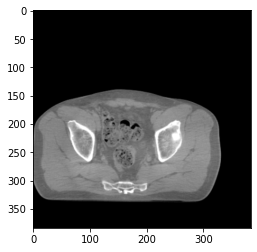

In [20]:
plt.imshow(x.squeeze(), 'gray'),

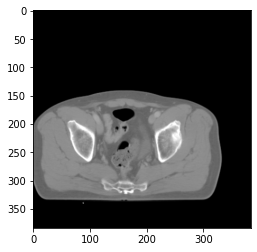

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [23]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [25]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [26]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [28]:
wandb.watch(model)
wandb.watch(discriminator)

min_mae = 99999

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_mae_test < min_mae:
            min_mae = score_mae_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

168it [02:39,  1.05it/s]
168it [00:47,  3.53it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.05it/s]
168it [00:47,  3.51it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.35it/s]
168it [02:40,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:41,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.05it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.05it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:47,

In [29]:
checkpoint = torch.load(os.path.join("{}.pth".format(wandb.run.name)))

In [30]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [31]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8994720578193665
psnr score = 26.08666229248047
snr score = 16.149599075317383
mae error = 0.015180455520749092
air dice score = 0.9980111336538193
bone dice score = 0.9449957470946272


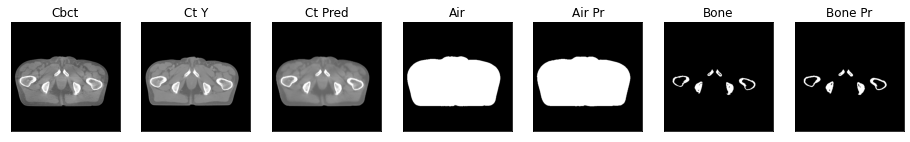

ssim score = 0.8994032740592957
psnr score = 25.964752197265625
snr score = 16.075225830078125
mae error = 0.015395830385386944
air dice score = 0.9984425853083896
bone dice score = 0.9447956173627645


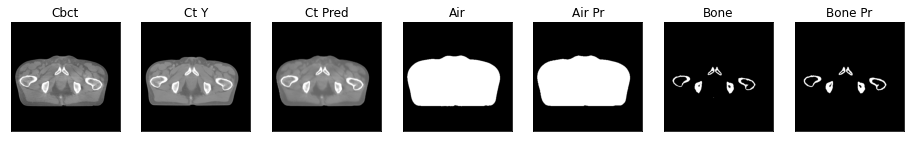

ssim score = 0.8960069417953491
psnr score = 25.760120391845703
snr score = 16.033491134643555
mae error = 0.016316808760166168
air dice score = 0.9983419233688937
bone dice score = 0.9439569439575995


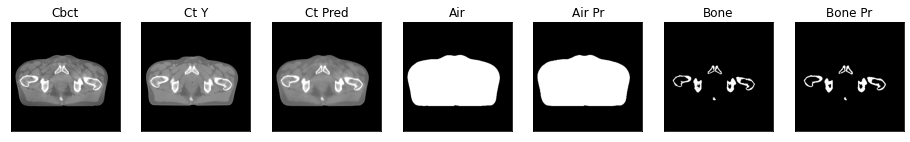

ssim score = 0.892512321472168
psnr score = 25.8176326751709
snr score = 16.180253982543945
mae error = 0.016394929960370064
air dice score = 0.9981393673849127
bone dice score = 0.9363732767769207


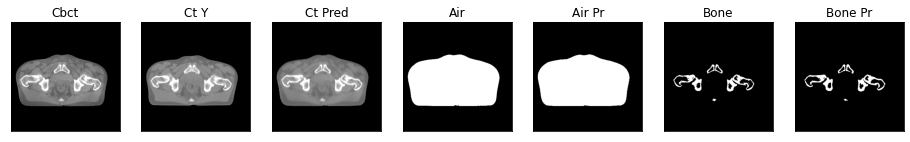

ssim score = 0.8911030888557434
psnr score = 25.88010025024414
snr score = 16.28302574157715
mae error = 0.016567878425121307
air dice score = 0.9979022172259102
bone dice score = 0.9377743844251024


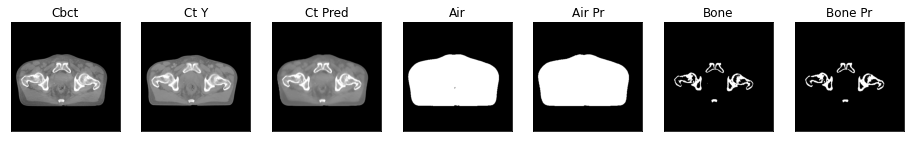

ssim score = 0.8854785561561584
psnr score = 25.72585678100586
snr score = 16.265317916870117
mae error = 0.017132695764303207
air dice score = 0.9979035216804101
bone dice score = 0.9308897141940022


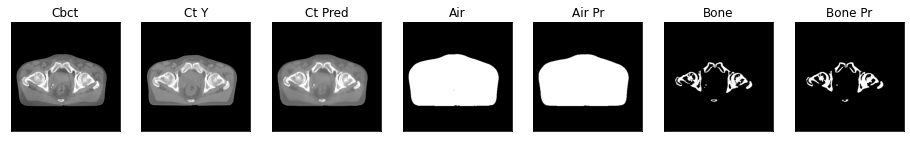

ssim score = 0.8820566534996033
psnr score = 25.524492263793945
snr score = 16.039894104003906
mae error = 0.017623959109187126
air dice score = 0.9976556077659285
bone dice score = 0.9414881184266343


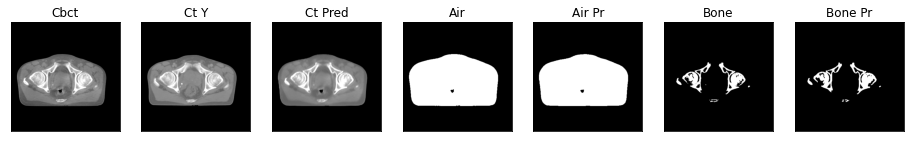

ssim score = 0.8839707970619202
psnr score = 25.865060806274414
snr score = 16.194927215576172
mae error = 0.016888532787561417
air dice score = 0.997948246822847
bone dice score = 0.9455415918616266


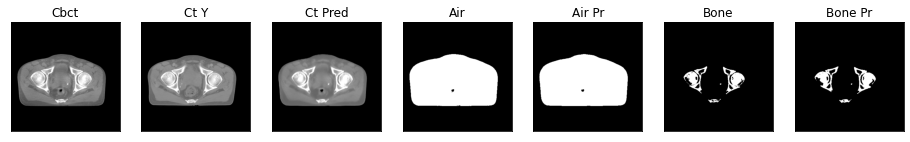

1it [00:02,  2.76s/it]

ssim score = 0.8869704604148865
psnr score = 26.278636932373047
snr score = 16.513946533203125
mae error = 0.016134150326251984
air dice score = 0.9980706075533682
bone dice score = 0.9482983076069528


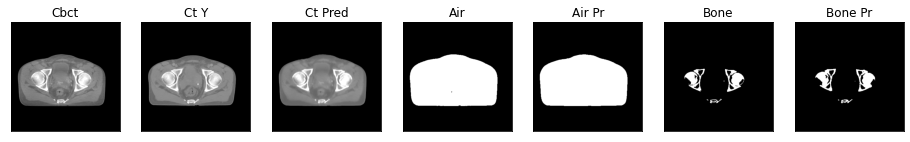

ssim score = 0.8918050527572632
psnr score = 26.42371940612793
snr score = 16.643749237060547
mae error = 0.015745779499411583
air dice score = 0.9981371473516464
bone dice score = 0.9458252427189726


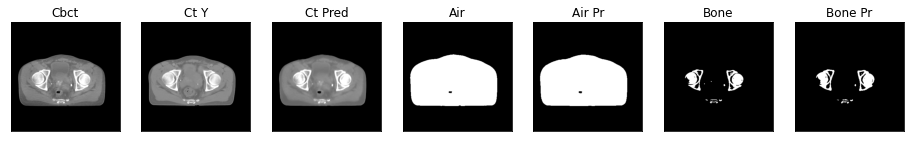

ssim score = 0.8981667160987854
psnr score = 27.006813049316406
snr score = 17.25910758972168
mae error = 0.014774304814636707
air dice score = 0.9979067515074536
bone dice score = 0.9517113018307134


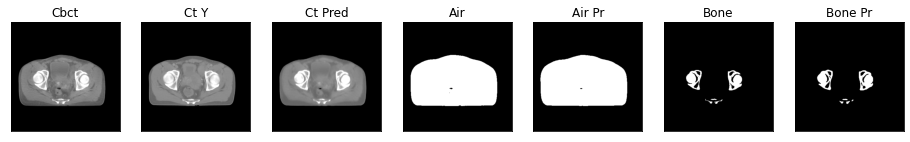

ssim score = 0.8982051014900208
psnr score = 26.192550659179688
snr score = 16.46855926513672
mae error = 0.015320786274969578
air dice score = 0.9979774144614887
bone dice score = 0.9623326761444191


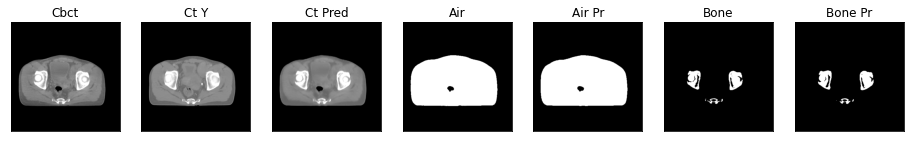

ssim score = 0.9033955335617065
psnr score = 25.541383743286133
snr score = 15.785469055175781
mae error = 0.015590980648994446
air dice score = 0.997677045372208
bone dice score = 0.9647660331225435


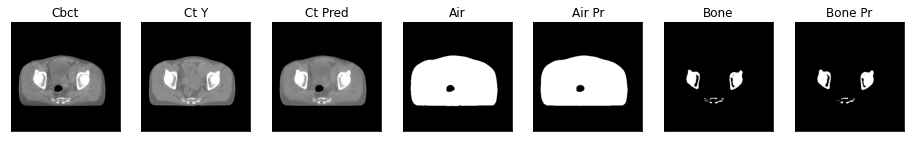

ssim score = 0.9003908634185791
psnr score = 25.22368621826172
snr score = 15.325814247131348
mae error = 0.016098199412226677
air dice score = 0.9975185037974438
bone dice score = 0.9515364994540078


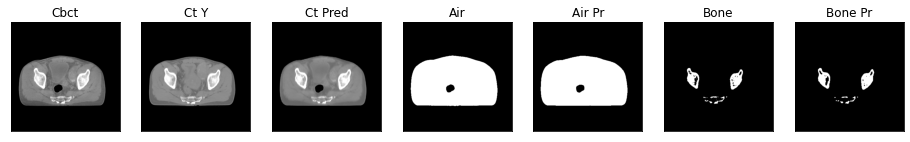

ssim score = 0.8979211449623108
psnr score = 25.044851303100586
snr score = 15.061317443847656
mae error = 0.016674602404236794
air dice score = 0.9976095445154757
bone dice score = 0.9373555840829608


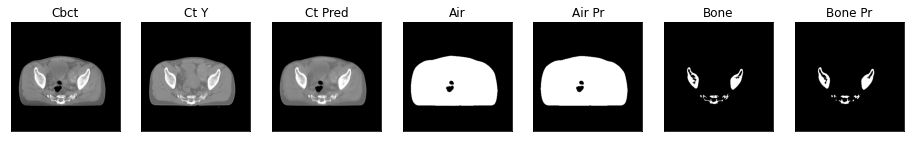

ssim score = 0.8899931311607361
psnr score = 24.653850555419922
snr score = 14.693799018859863
mae error = 0.01766934059560299
air dice score = 0.9978807342440765
bone dice score = 0.9366249078858189


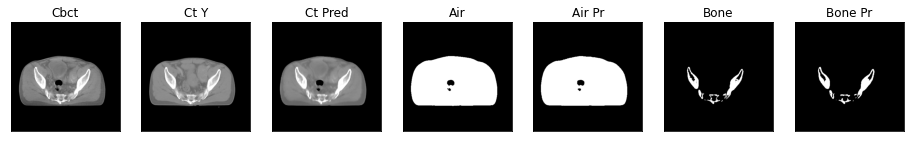

2it [00:04,  2.55s/it]

ssim score = 0.8865959644317627
psnr score = 23.909273147583008
snr score = 13.946681022644043
mae error = 0.01893768087029457
air dice score = 0.9979869094109257
bone dice score = 0.9400395855170561


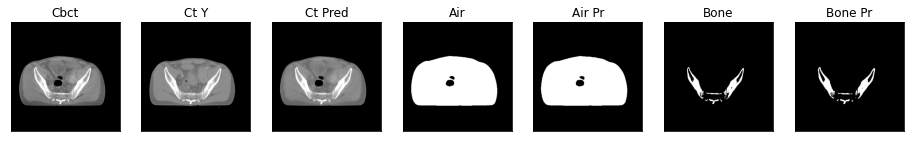

ssim score = 0.880187451839447
psnr score = 23.217884063720703
snr score = 13.15353012084961
mae error = 0.020519783720374107
air dice score = 0.9969109988513857
bone dice score = 0.9221443004882663


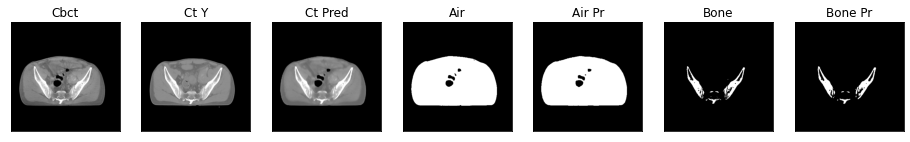

ssim score = 0.877323567867279
psnr score = 22.857091903686523
snr score = 12.742055892944336
mae error = 0.02137409709393978
air dice score = 0.9970959027465138
bone dice score = 0.9209033005220508


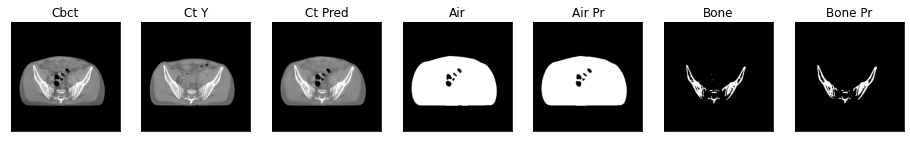

ssim score = 0.8804839253425598
psnr score = 22.852861404418945
snr score = 12.725520133972168
mae error = 0.02124577760696411
air dice score = 0.9974540887334968
bone dice score = 0.9263862332704781


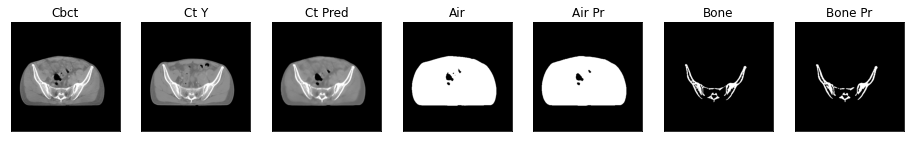

ssim score = 0.8778694272041321
psnr score = 22.731014251708984
snr score = 12.538822174072266
mae error = 0.021426506340503693
air dice score = 0.9979390834044999
bone dice score = 0.9131339401831842


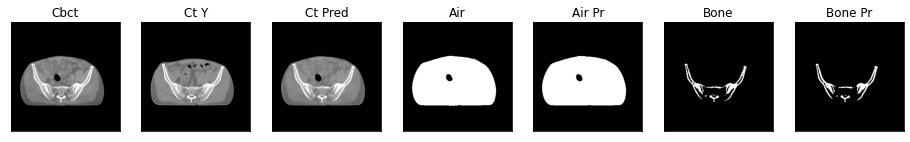

ssim score = 0.874366044998169
psnr score = 22.696243286132812
snr score = 12.444619178771973
mae error = 0.021136963739991188
air dice score = 0.9969172015552064
bone dice score = 0.9163664436449258


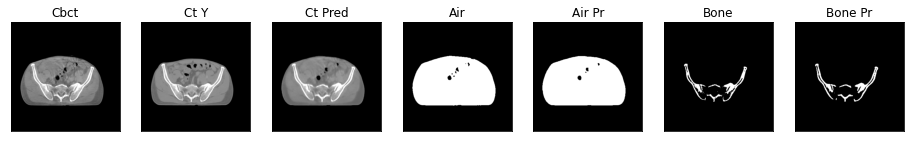

ssim score = 0.8790624141693115
psnr score = 22.858661651611328
snr score = 12.573614120483398
mae error = 0.020652491599321365
air dice score = 0.9975557486243875
bone dice score = 0.9200480192086428


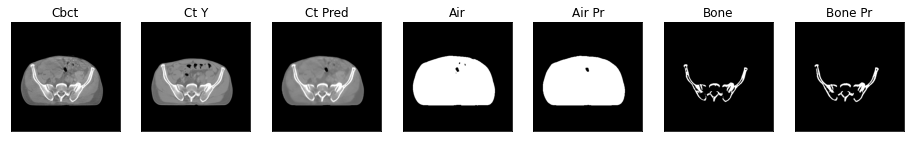

ssim score = 0.8795676231384277
psnr score = 22.896738052368164
snr score = 12.563124656677246
mae error = 0.02086489461362362
air dice score = 0.9972024861587475
bone dice score = 0.916946600255798


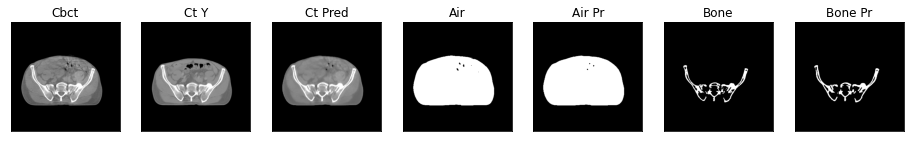

3it [00:07,  2.47s/it]

ssim score = 0.8798525333404541
psnr score = 22.806453704833984
snr score = 12.37584114074707
mae error = 0.021223798394203186
air dice score = 0.9978398651696088
bone dice score = 0.9188224799295404


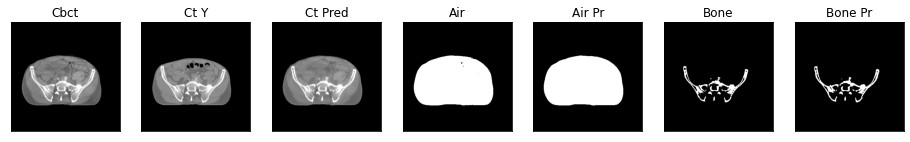

ssim score = 0.8835287094116211
psnr score = 23.053571701049805
snr score = 12.54022216796875
mae error = 0.020422108471393585
air dice score = 0.9976002327047103
bone dice score = 0.9122962634448132


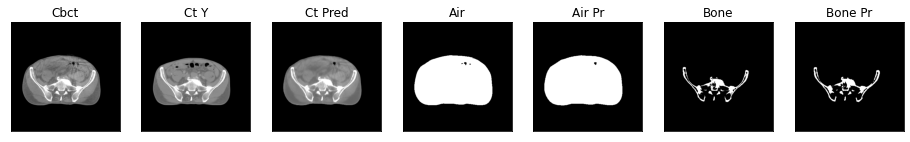

ssim score = 0.8834319710731506
psnr score = 23.205669403076172
snr score = 12.601136207580566
mae error = 0.02043185569345951
air dice score = 0.9974403679934742
bone dice score = 0.9200301366922825


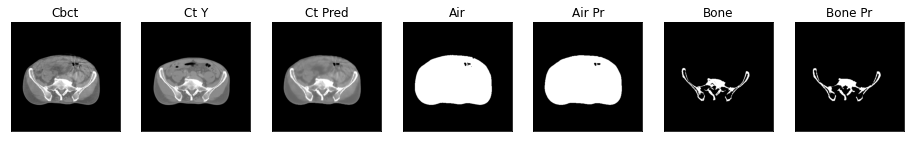

ssim score = 0.8842499256134033
psnr score = 23.032371520996094
snr score = 12.386731147766113
mae error = 0.020724546164274216
air dice score = 0.9972224666004785
bone dice score = 0.9229977352282994


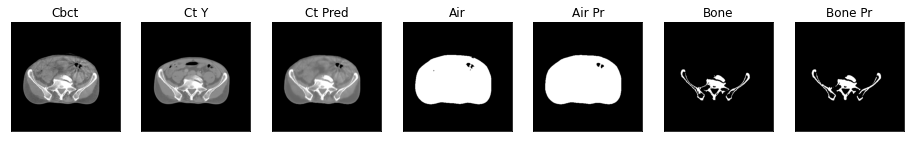

ssim score = 0.8738828897476196
psnr score = 23.80079460144043
snr score = 15.172952651977539
mae error = 0.021368294954299927
air dice score = 0.9982749137456883
bone dice score = 0.97084367245748


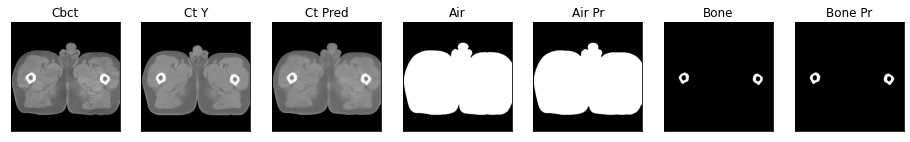

ssim score = 0.8799630999565125
psnr score = 24.368398666381836
snr score = 15.779814720153809
mae error = 0.020203877240419388
air dice score = 0.998320827317848
bone dice score = 0.9717283590798097


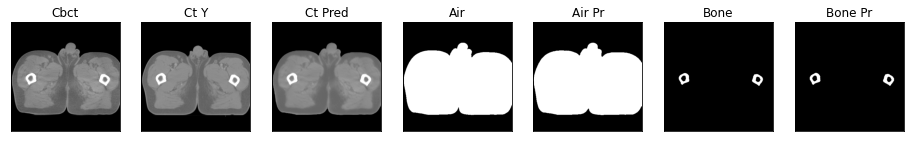

ssim score = 0.8864500522613525
psnr score = 24.868688583374023
snr score = 16.367551803588867
mae error = 0.019551899284124374
air dice score = 0.9984375384463975
bone dice score = 0.970977478524008


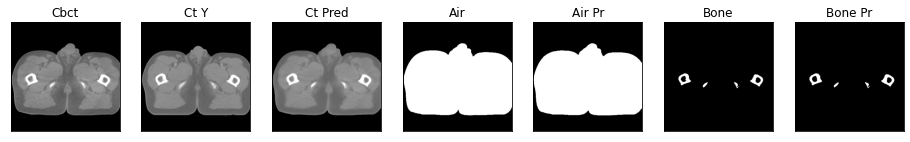

ssim score = 0.8904486298561096
psnr score = 25.1866455078125
snr score = 16.848066329956055
mae error = 0.01936613768339157
air dice score = 0.998398376369328
bone dice score = 0.9662387066101404


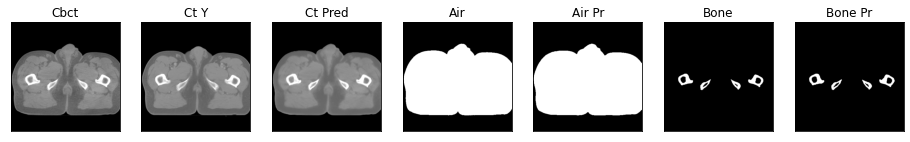

4it [00:09,  2.35s/it]

ssim score = 0.8931698799133301
psnr score = 25.485130310058594
snr score = 17.27469253540039
mae error = 0.019149580970406532
air dice score = 0.9985817847599695
bone dice score = 0.9553727922346585


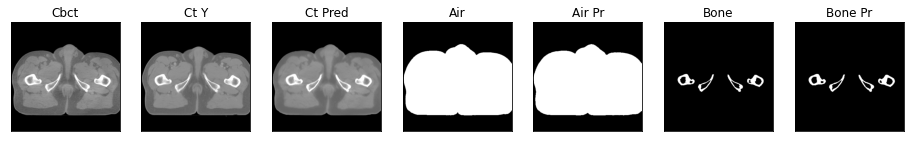

ssim score = 0.8951346278190613
psnr score = 25.96651268005371
snr score = 17.859315872192383
mae error = 0.01881944201886654
air dice score = 0.998635859317688
bone dice score = 0.9464327485386381


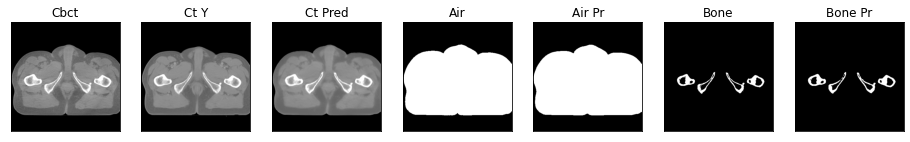

ssim score = 0.8969271183013916
psnr score = 26.416702270507812
snr score = 18.376604080200195
mae error = 0.01871854066848755
air dice score = 0.9986225229579515
bone dice score = 0.9439914163096138


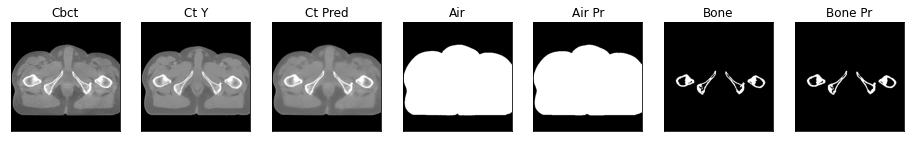

ssim score = 0.8957615494728088
psnr score = 26.427146911621094
snr score = 18.377159118652344
mae error = 0.01897440478205681
air dice score = 0.9986932984879605
bone dice score = 0.9519722051915801


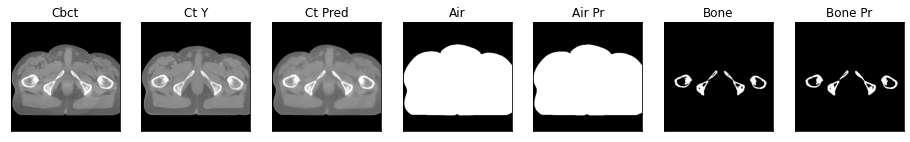

ssim score = 0.8984627723693848
psnr score = 26.440757751464844
snr score = 18.377107620239258
mae error = 0.018838420510292053
air dice score = 0.9988039931004232
bone dice score = 0.9561182285891645


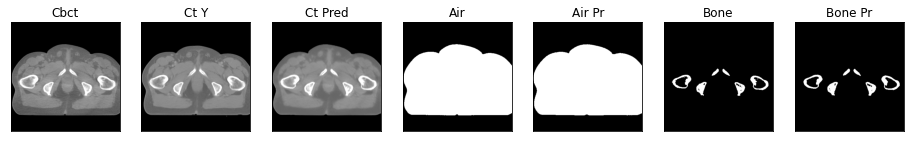

ssim score = 0.8994307518005371
psnr score = 26.73193359375
snr score = 18.68028450012207
mae error = 0.018499035388231277
air dice score = 0.998757585033402
bone dice score = 0.9547008547013387


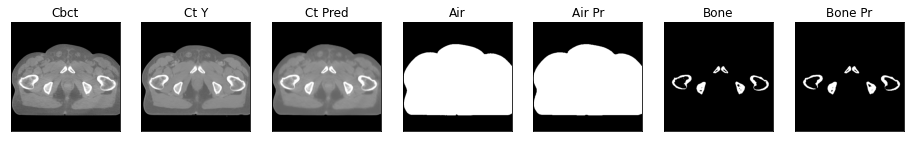

ssim score = 0.9013617038726807
psnr score = 26.880319595336914
snr score = 18.867752075195312
mae error = 0.018201379105448723
air dice score = 0.9986022879286875
bone dice score = 0.950952485220594


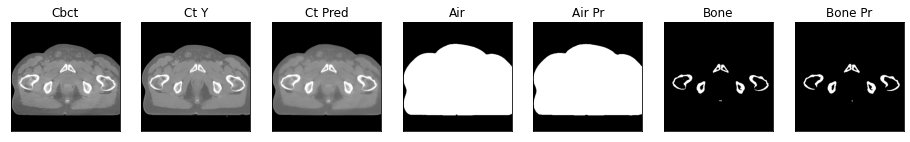

ssim score = 0.898345947265625
psnr score = 26.79107666015625
snr score = 18.9197998046875
mae error = 0.018837833777070045
air dice score = 0.998632355587548
bone dice score = 0.9503731343288212


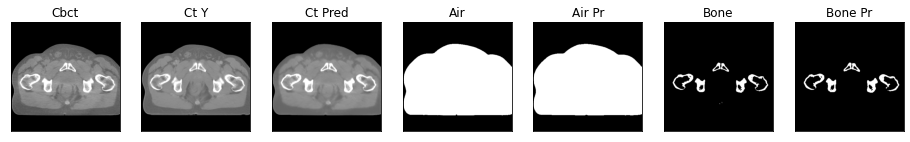

5it [00:11,  2.33s/it]

ssim score = 0.8962897658348083
psnr score = 26.671228408813477
snr score = 18.894638061523438
mae error = 0.019545936957001686
air dice score = 0.9984924472206381
bone dice score = 0.9528811988262561


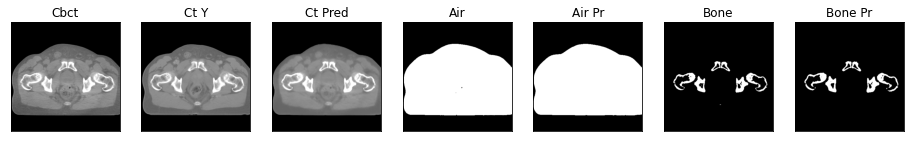

ssim score = 0.8854737877845764
psnr score = 25.874366760253906
snr score = 18.063732147216797
mae error = 0.021466834470629692
air dice score = 0.9979621858872342
bone dice score = 0.9376278893525


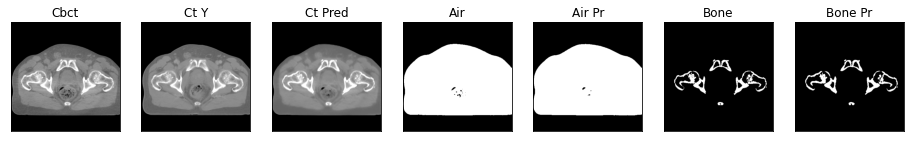

ssim score = 0.8845734000205994
psnr score = 25.165435791015625
snr score = 17.426984786987305
mae error = 0.022405501455068588
air dice score = 0.9976866047737319
bone dice score = 0.9306148867318407


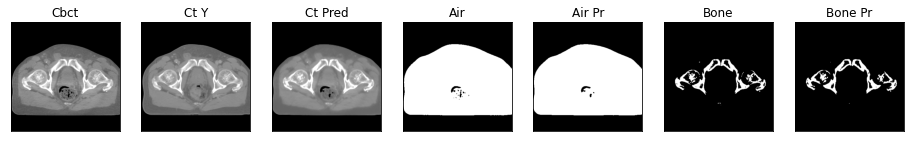

ssim score = 0.8831724524497986
psnr score = 25.224735260009766
snr score = 17.350191116333008
mae error = 0.021951468661427498
air dice score = 0.9982944300960003
bone dice score = 0.9197806832566868


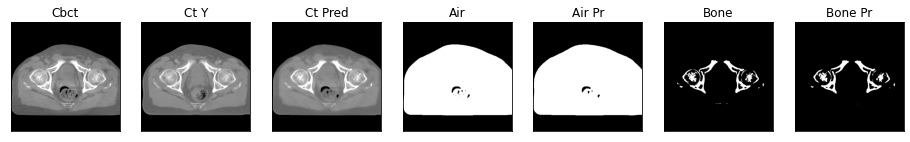

ssim score = 0.8877121210098267
psnr score = 25.3127384185791
snr score = 17.259632110595703
mae error = 0.021505801007151604
air dice score = 0.9983575026713489
bone dice score = 0.9110185535790324


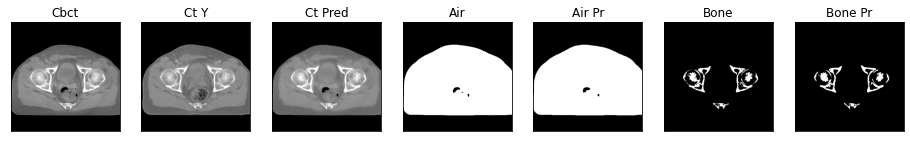

ssim score = 0.8854129314422607
psnr score = 25.3856258392334
snr score = 17.241928100585938
mae error = 0.021705390885472298
air dice score = 0.9987103714252543
bone dice score = 0.8970320368595625


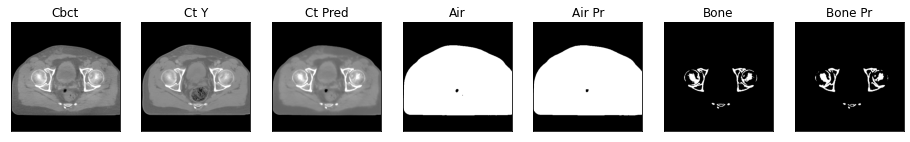

ssim score = 0.8842979073524475
psnr score = 25.41118621826172
snr score = 17.283180236816406
mae error = 0.021558592095971107
air dice score = 0.9987915815559775
bone dice score = 0.9265768404615644


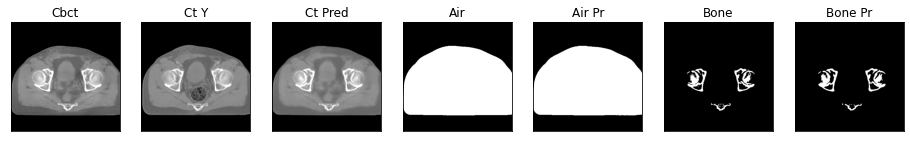

ssim score = 0.8726524114608765
psnr score = 25.202316284179688
snr score = 17.084348678588867
mae error = 0.02260022796690464
air dice score = 0.9986001221038878
bone dice score = 0.9334281397215054


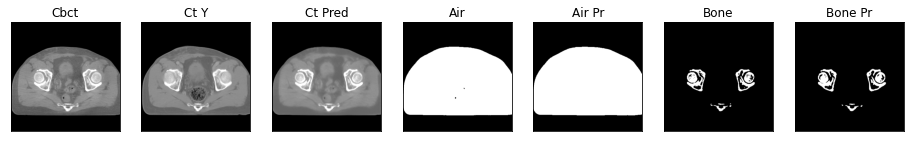

6it [00:13,  2.26s/it]

ssim score = 0.8820871710777283
psnr score = 25.801605224609375
snr score = 17.745227813720703
mae error = 0.021138247102499008
air dice score = 0.9984713738450218
bone dice score = 0.9471170249066264


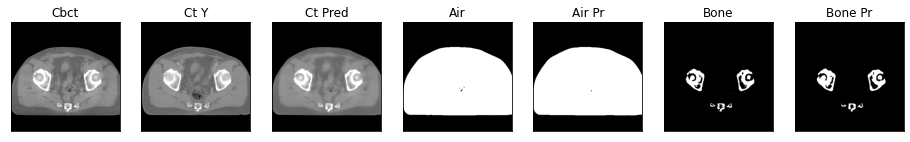

ssim score = 0.8833307027816772
psnr score = 26.510589599609375
snr score = 18.5242919921875
mae error = 0.019756967201828957
air dice score = 0.9983183056463985
bone dice score = 0.9614896318242786


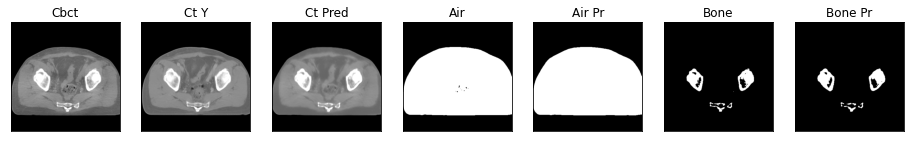

ssim score = 0.8858673572540283
psnr score = 25.783842086791992
snr score = 17.67844009399414
mae error = 0.021351266652345657
air dice score = 0.9981757939019408
bone dice score = 0.9482152764939134


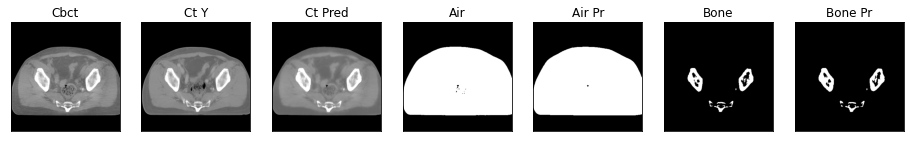

ssim score = 0.8779956102371216
psnr score = 25.2296142578125
snr score = 17.205839157104492
mae error = 0.02274967171251774
air dice score = 0.9981135587961538
bone dice score = 0.9536499632146355


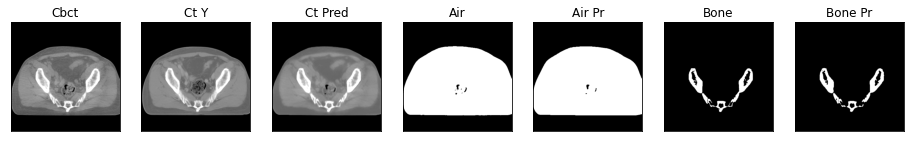

ssim score = 0.8777980208396912
psnr score = 25.124568939208984
snr score = 17.180940628051758
mae error = 0.023110628128051758
air dice score = 0.9978977917511593
bone dice score = 0.9536862003783845


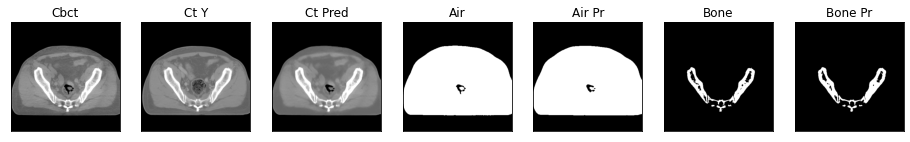

ssim score = 0.8636634349822998
psnr score = 24.573135375976562
snr score = 16.651063919067383
mae error = 0.025162920355796814
air dice score = 0.998454672452374
bone dice score = 0.9423918992888451


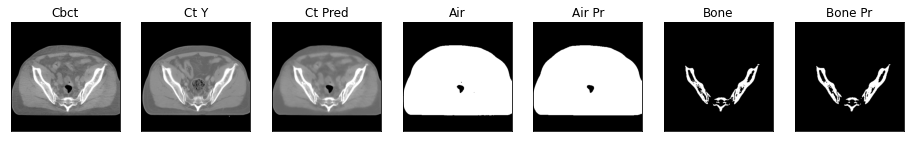

ssim score = 0.8649120926856995
psnr score = 25.056365966796875
snr score = 17.146833419799805
mae error = 0.024570265784859657
air dice score = 0.9983386769492969
bone dice score = 0.945819022920405


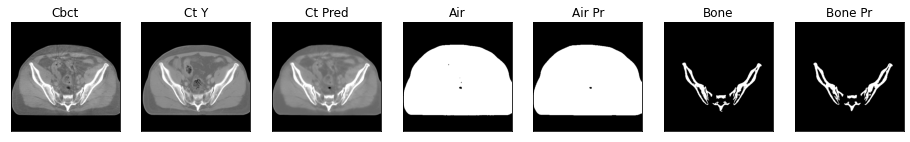

ssim score = 0.8172378540039062
psnr score = 20.95557403564453
snr score = 10.83578109741211
mae error = 0.03282851353287697
air dice score = 0.9889645675152701
bone dice score = 0.9535135135147699


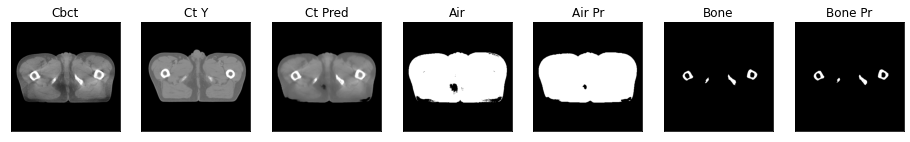

7it [00:15,  2.28s/it]

ssim score = 0.8063980937004089
psnr score = 20.58397102355957
snr score = 10.677157402038574
mae error = 0.035191893577575684
air dice score = 0.9895826581352591
bone dice score = 0.9293501962509955


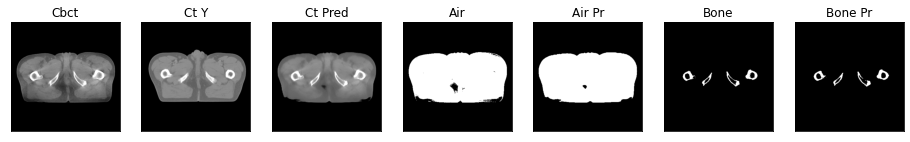

ssim score = 0.8028745055198669
psnr score = 20.636611938476562
snr score = 10.860939025878906
mae error = 0.035335082560777664
air dice score = 0.9886580014902
bone dice score = 0.9052982895305528


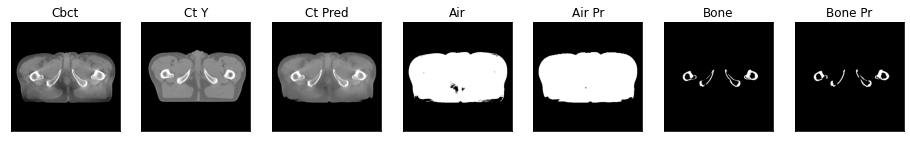

ssim score = 0.8040539026260376
psnr score = 20.843713760375977
snr score = 11.138442993164062
mae error = 0.034638624638319016
air dice score = 0.9890089624903284
bone dice score = 0.9106858054244281


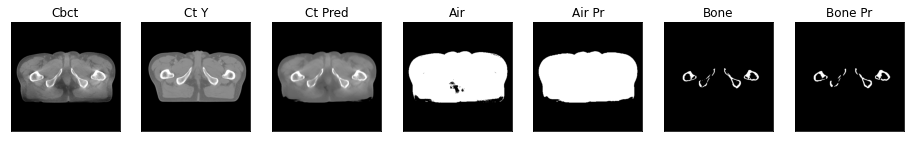

ssim score = 0.8053125739097595
psnr score = 20.860187530517578
snr score = 11.202483177185059
mae error = 0.0346074178814888
air dice score = 0.9897696800499671
bone dice score = 0.9051808406665653


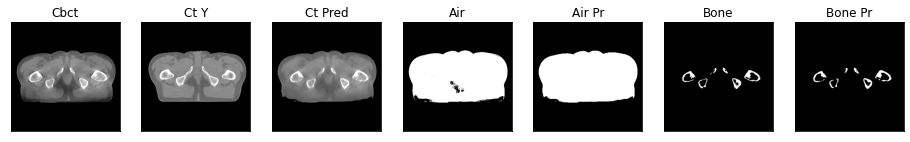

ssim score = 0.8060455322265625
psnr score = 20.99541664123535
snr score = 11.343330383300781
mae error = 0.03417651727795601
air dice score = 0.9895166680400386
bone dice score = 0.9097772744448891


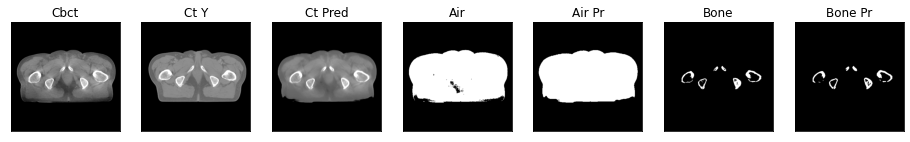

ssim score = 0.8092418313026428
psnr score = 21.119850158691406
snr score = 11.461259841918945
mae error = 0.03342661261558533
air dice score = 0.9907592384809841
bone dice score = 0.9191521290579787


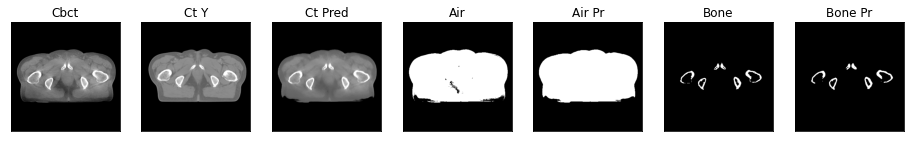

ssim score = 0.8088709115982056
psnr score = 21.02939796447754
snr score = 11.384918212890625
mae error = 0.03351442888379097
air dice score = 0.9920317641619827
bone dice score = 0.9259796806980047


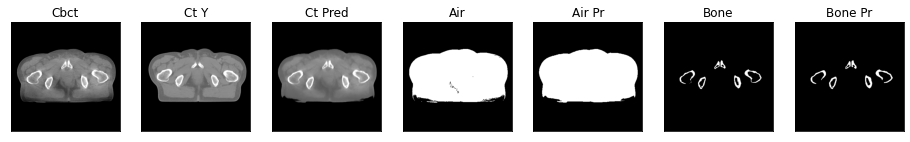

ssim score = 0.8075358867645264
psnr score = 20.954092025756836
snr score = 11.3676176071167
mae error = 0.03432078659534454
air dice score = 0.9927906766645652
bone dice score = 0.9150516795879352


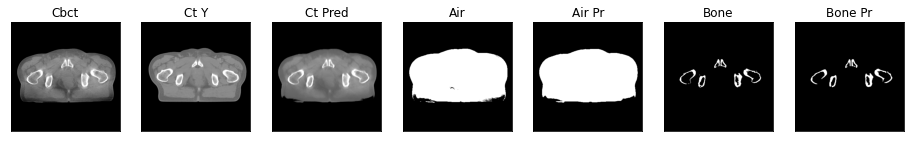

8it [00:18,  2.28s/it]

ssim score = 0.8000224828720093
psnr score = 20.799358367919922
snr score = 11.311444282531738
mae error = 0.035878587514162064
air dice score = 0.9933865656155606
bone dice score = 0.8902554399260445


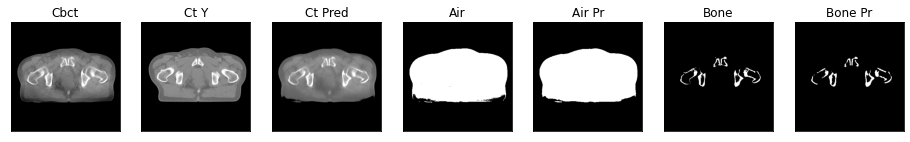

ssim score = 0.7872076034545898
psnr score = 20.579761505126953
snr score = 11.127676963806152
mae error = 0.037587929517030716
air dice score = 0.992560837221038
bone dice score = 0.8895880149829275


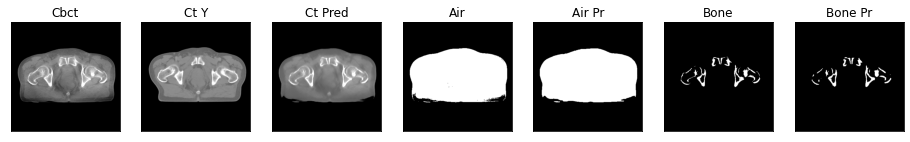

ssim score = 0.7754818797111511
psnr score = 20.432607650756836
snr score = 11.013230323791504
mae error = 0.037960249930620193
air dice score = 0.9927826063509534
bone dice score = 0.8734737689537975


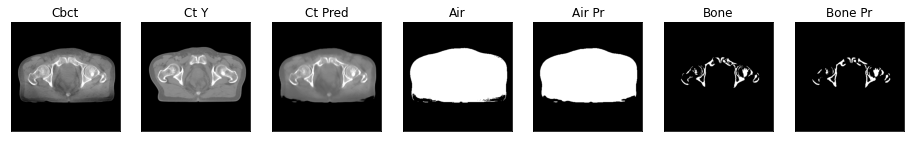

ssim score = 0.7773696184158325
psnr score = 20.559589385986328
snr score = 11.257028579711914
mae error = 0.038186509162187576
air dice score = 0.9922540457576834
bone dice score = 0.8914708212319584


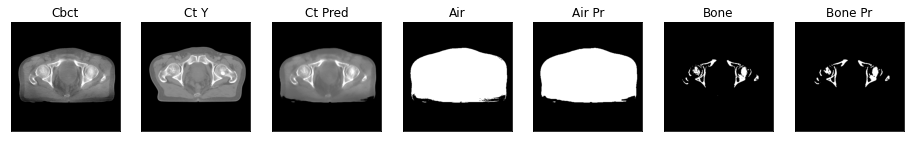

ssim score = 0.782289445400238
psnr score = 20.53897476196289
snr score = 11.22042465209961
mae error = 0.038294363766908646
air dice score = 0.9910029511755447
bone dice score = 0.867180551439858


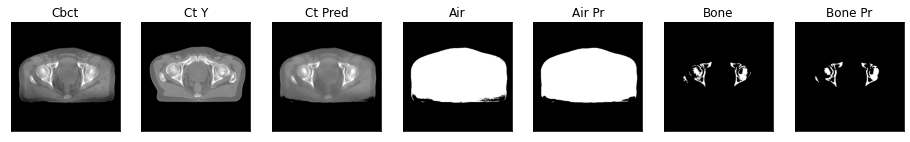

ssim score = 0.796419620513916
psnr score = 21.026506423950195
snr score = 11.508792877197266
mae error = 0.03493969514966011
air dice score = 0.9901457072405379
bone dice score = 0.905506883605984


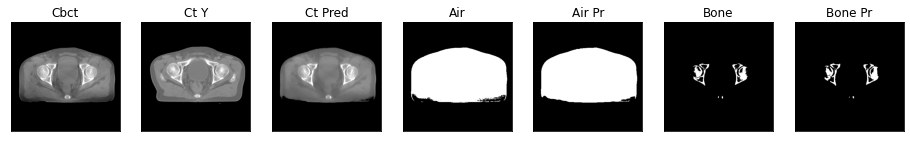

ssim score = 0.8125287294387817
psnr score = 21.633920669555664
snr score = 11.945816040039062
mae error = 0.03212282806634903
air dice score = 0.989809624442583
bone dice score = 0.9357486555344502


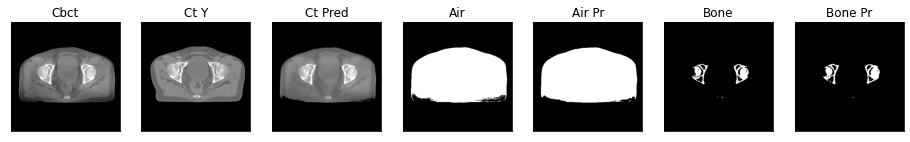

ssim score = 0.8188492655754089
psnr score = 21.899551391601562
snr score = 12.225614547729492
mae error = 0.031217629089951515
air dice score = 0.9900619225564875
bone dice score = 0.9370555701878186


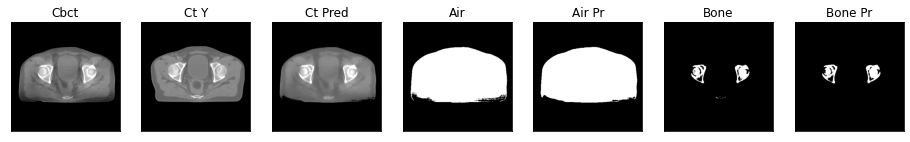

9it [00:20,  2.21s/it]

ssim score = 0.8216120004653931
psnr score = 21.982975006103516
snr score = 12.390867233276367
mae error = 0.03103550709784031
air dice score = 0.990678019325847
bone dice score = 0.9481655568618859


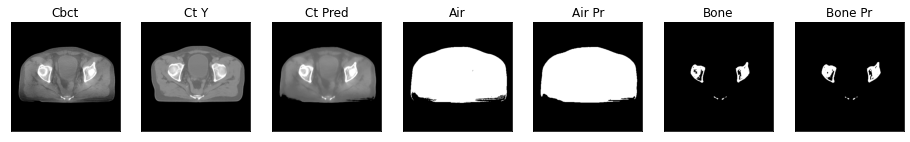

ssim score = 0.8198118805885315
psnr score = 21.852313995361328
snr score = 12.352380752563477
mae error = 0.031631484627723694
air dice score = 0.9903095558546521
bone dice score = 0.934691431996185


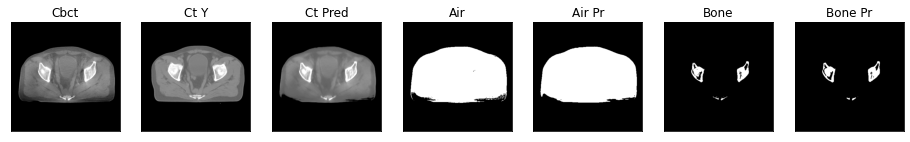

ssim score = 0.8175429105758667
psnr score = 22.213790893554688
snr score = 12.650430679321289
mae error = 0.03035144694149494
air dice score = 0.9892828579045683
bone dice score = 0.9531428571436221


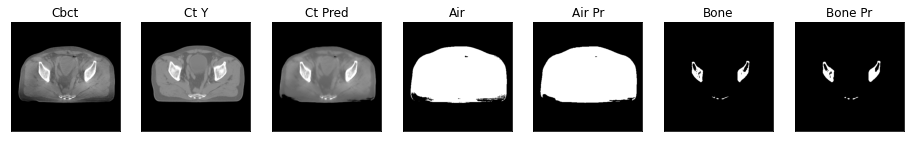

ssim score = 0.8223620653152466
psnr score = 22.453718185424805
snr score = 12.853963851928711
mae error = 0.028978440910577774
air dice score = 0.9888441551531589
bone dice score = 0.9464222770541695


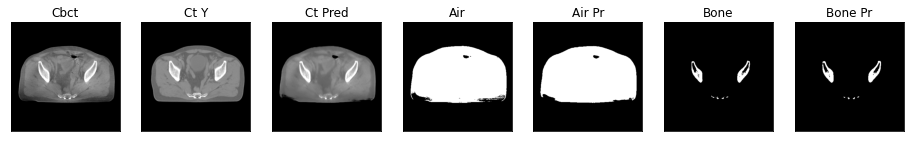

ssim score = 0.8174753189086914
psnr score = 22.229293823242188
snr score = 12.66728401184082
mae error = 0.030418945476412773
air dice score = 0.9885539397799344
bone dice score = 0.9286415711959306


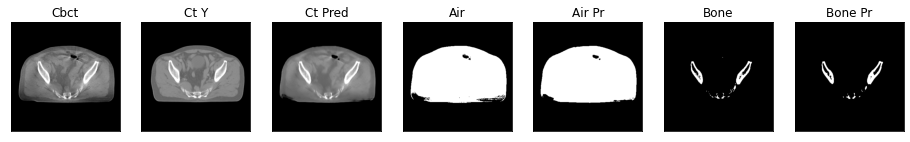

ssim score = 0.8146295547485352
psnr score = 22.173519134521484
snr score = 12.742013931274414
mae error = 0.031003989279270172
air dice score = 0.9886397766824008
bone dice score = 0.9221299742352973


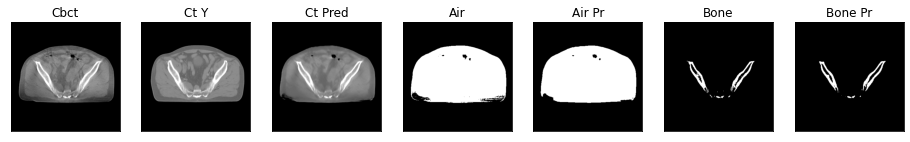

ssim score = 0.8168155550956726
psnr score = 22.134201049804688
snr score = 12.72044563293457
mae error = 0.03105279803276062
air dice score = 0.987596474322149
bone dice score = 0.9015673981206651


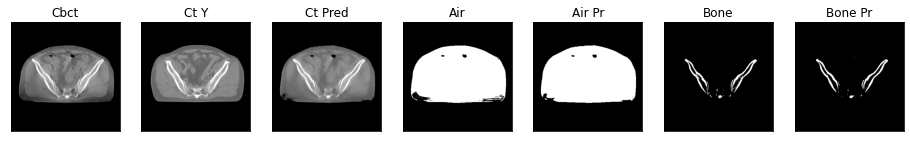

ssim score = 0.8192706108093262
psnr score = 22.569456100463867
snr score = 13.144432067871094
mae error = 0.02974812127649784
air dice score = 0.9878361018826243
bone dice score = 0.9046404895477709


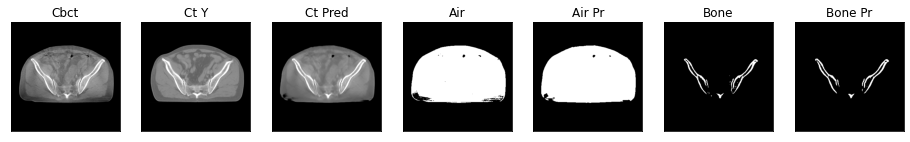

10it [00:22,  2.24s/it]

ssim score = 0.8227516412734985
psnr score = 22.74095344543457
snr score = 13.315186500549316
mae error = 0.02933693304657936
air dice score = 0.9871031305752669
bone dice score = 0.8932780083005265


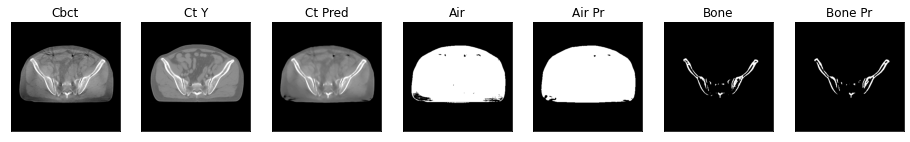

ssim score = 0.8828653693199158
psnr score = 24.392738342285156
snr score = 14.826871871948242
mae error = 0.019301095977425575
air dice score = 0.9981302084172874
bone dice score = 0.9449886963095332


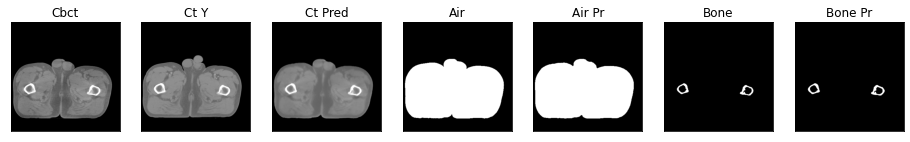

ssim score = 0.8822876811027527
psnr score = 24.655460357666016
snr score = 15.1539888381958
mae error = 0.019077638164162636
air dice score = 0.997980057071405
bone dice score = 0.9356073790485344


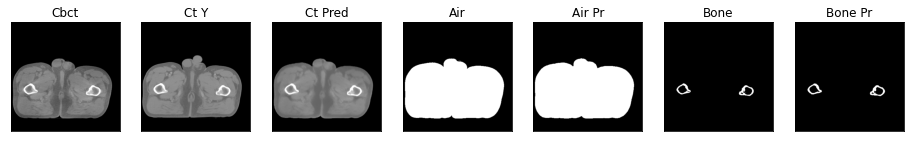

ssim score = 0.8876303434371948
psnr score = 26.135665893554688
snr score = 16.773406982421875
mae error = 0.018021686002612114
air dice score = 0.9975591587022351
bone dice score = 0.938354629008331


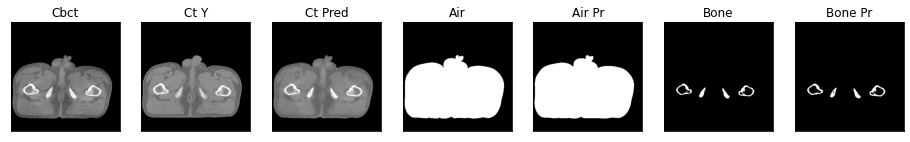

ssim score = 0.889064371585846
psnr score = 26.113143920898438
snr score = 16.872371673583984
mae error = 0.01818300224840641
air dice score = 0.9981410003938573
bone dice score = 0.9212328767140147


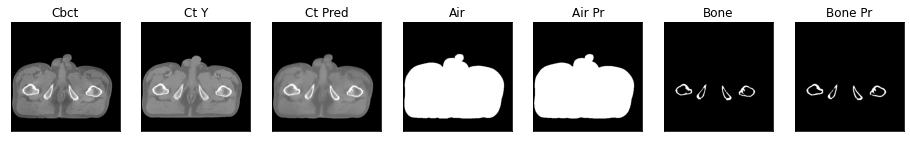

ssim score = 0.8859533667564392
psnr score = 25.968076705932617
snr score = 16.751482009887695
mae error = 0.01814972795546055
air dice score = 0.9982393812682757
bone dice score = 0.9072670530560127


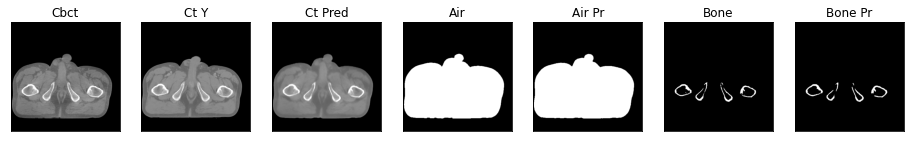

ssim score = 0.8877263069152832
psnr score = 25.873613357543945
snr score = 16.65262222290039
mae error = 0.017992526292800903
air dice score = 0.9984855499493888
bone dice score = 0.8982109808780956


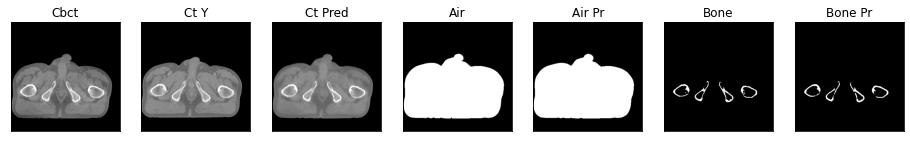

ssim score = 0.8882825970649719
psnr score = 25.35550308227539
snr score = 16.140764236450195
mae error = 0.018845748156309128
air dice score = 0.9979923143282895
bone dice score = 0.8978043912196046


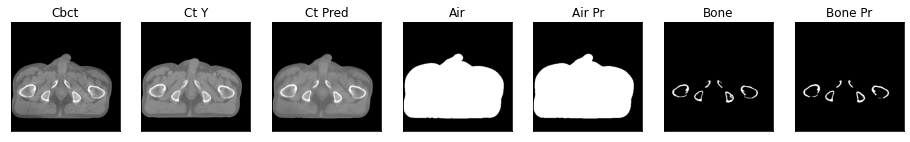

11it [00:24,  2.19s/it]

ssim score = 0.8850052356719971
psnr score = 25.032501220703125
snr score = 15.796205520629883
mae error = 0.01894828863441944
air dice score = 0.9980445282129831
bone dice score = 0.9058155472898802


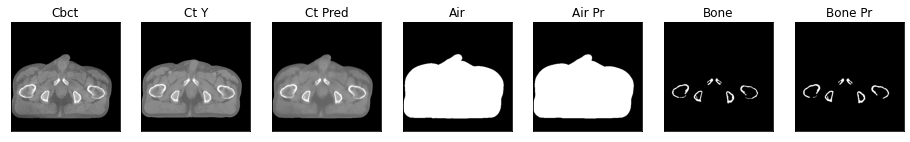

ssim score = 0.8864294290542603
psnr score = 25.08561897277832
snr score = 15.866232872009277
mae error = 0.018926016986370087
air dice score = 0.9980542754736318
bone dice score = 0.9166208539505842


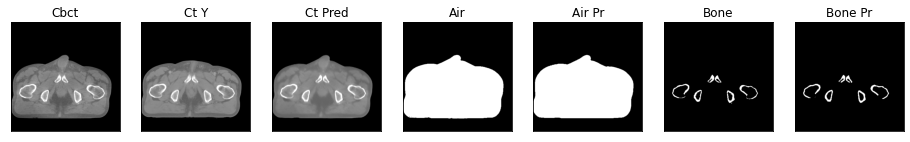

ssim score = 0.8868353366851807
psnr score = 25.39573860168457
snr score = 16.24494743347168
mae error = 0.018518375232815742
air dice score = 0.9981737831150057
bone dice score = 0.911122227782039


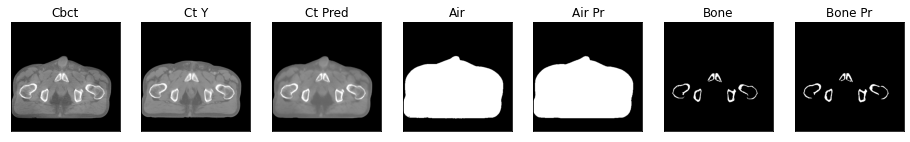

ssim score = 0.8863776922225952
psnr score = 25.774616241455078
snr score = 16.705184936523438
mae error = 0.0183112695813179
air dice score = 0.9983172733478336
bone dice score = 0.9156072905511471


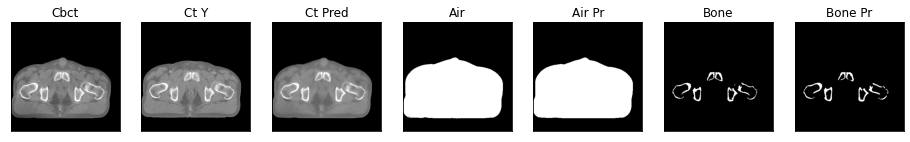

ssim score = 0.8868892788887024
psnr score = 26.19998550415039
snr score = 17.18125343322754
mae error = 0.01818351075053215
air dice score = 0.9980714365407006
bone dice score = 0.8956585724813001


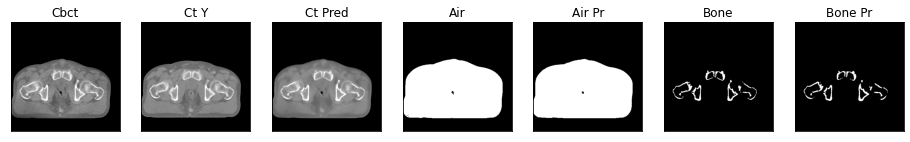

ssim score = 0.8893501162528992
psnr score = 26.65320587158203
snr score = 17.75074577331543
mae error = 0.01767018437385559
air dice score = 0.9977460555972971
bone dice score = 0.876010412386957


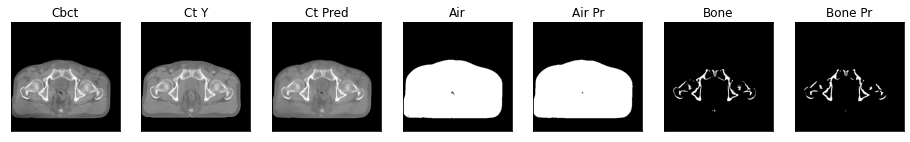

ssim score = 0.8895207047462463
psnr score = 26.276145935058594
snr score = 17.33544921875
mae error = 0.017783040180802345
air dice score = 0.9976431978507271
bone dice score = 0.8695271453609235


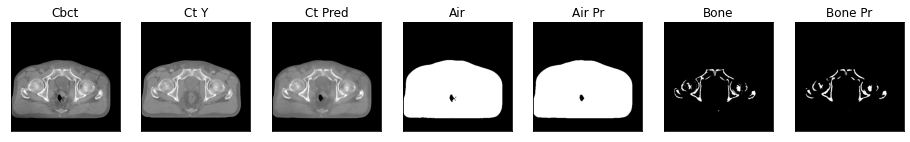

ssim score = 0.8826804161071777
psnr score = 25.452211380004883
snr score = 16.415843963623047
mae error = 0.01885708048939705
air dice score = 0.9971082771505182
bone dice score = 0.879173930536688


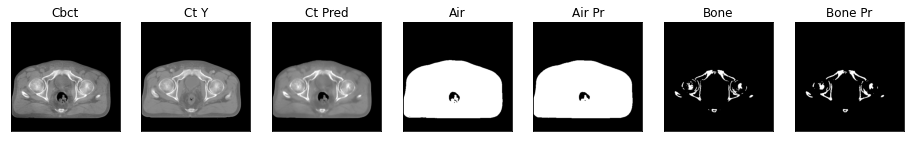

12it [00:26,  2.22s/it]

ssim score = 0.886363685131073
psnr score = 25.246898651123047
snr score = 16.0507755279541
mae error = 0.018676280975341797
air dice score = 0.9967853023697174
bone dice score = 0.8829308909261794


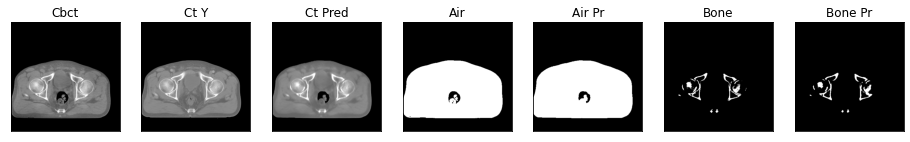

ssim score = 0.8842934966087341
psnr score = 24.817581176757812
snr score = 15.505029678344727
mae error = 0.01911855675280094
air dice score = 0.9972968728042281
bone dice score = 0.8761609907142043


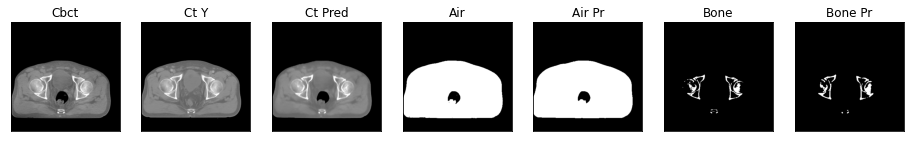

ssim score = 0.8803712725639343
psnr score = 24.689125061035156
snr score = 15.3314790725708
mae error = 0.019343405961990356
air dice score = 0.9972621890837093
bone dice score = 0.9034515667265237


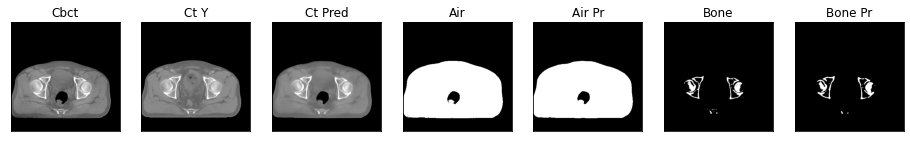

ssim score = 0.8737804889678955
psnr score = 24.040660858154297
snr score = 14.689688682556152
mae error = 0.020954472944140434
air dice score = 0.9972240515509488
bone dice score = 0.9236111111123168


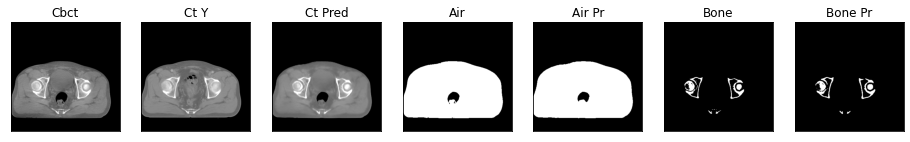

ssim score = 0.875880241394043
psnr score = 23.619230270385742
snr score = 14.298362731933594
mae error = 0.02210228517651558
air dice score = 0.9974178776458419
bone dice score = 0.9399084600628982


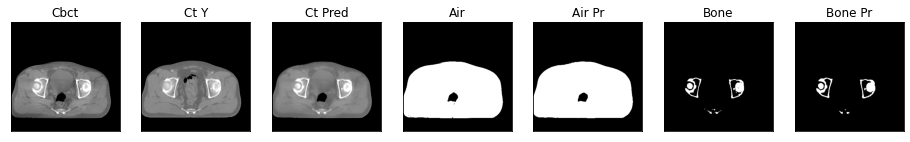

ssim score = 0.8829854130744934
psnr score = 24.350187301635742
snr score = 14.986732482910156
mae error = 0.020229585468769073
air dice score = 0.9973457532051304
bone dice score = 0.9243502731348394


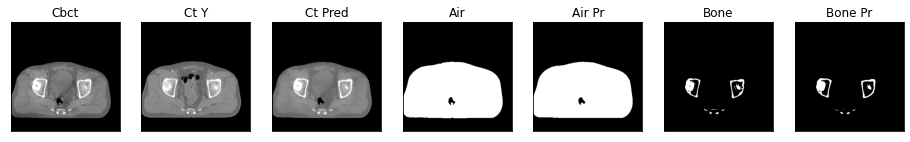

ssim score = 0.8846519589424133
psnr score = 24.70416831970215
snr score = 15.250509262084961
mae error = 0.01896027661859989
air dice score = 0.9973965963217527
bone dice score = 0.9138576779042349


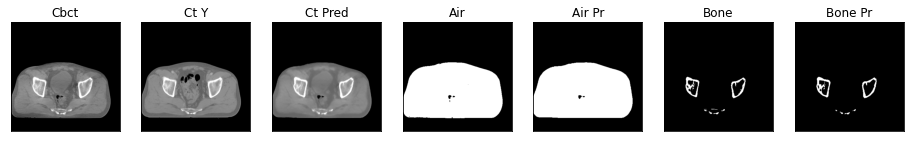

ssim score = 0.8847277164459229
psnr score = 24.323837280273438
snr score = 14.80445384979248
mae error = 0.019438741728663445
air dice score = 0.9974988592770373
bone dice score = 0.9249611197526252


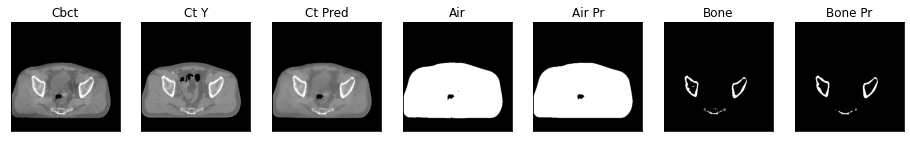

13it [00:28,  2.17s/it]

ssim score = 0.8829894661903381
psnr score = 24.39937400817871
snr score = 14.879688262939453
mae error = 0.019462285563349724
air dice score = 0.9973560316593909
bone dice score = 0.9298604017717081


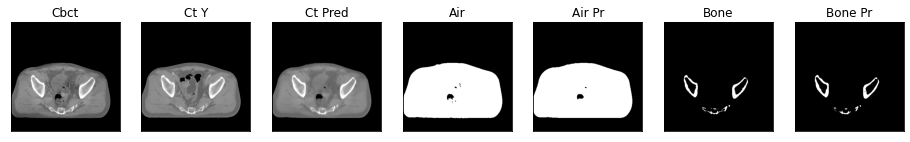

ssim score = 0.8766212463378906
psnr score = 24.252079010009766
snr score = 14.80855941772461
mae error = 0.020619036629796028
air dice score = 0.9973727959480784
bone dice score = 0.9276324892773262


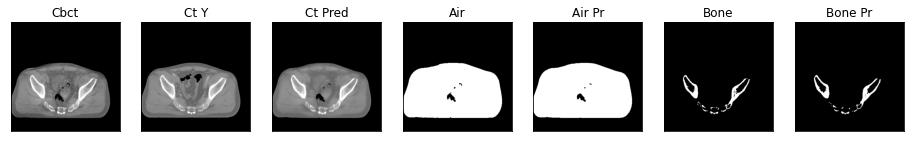

ssim score = 0.8815775513648987
psnr score = 24.51333999633789
snr score = 15.105401992797852
mae error = 0.020064231008291245
air dice score = 0.9962403077216992
bone dice score = 0.9227390180888535


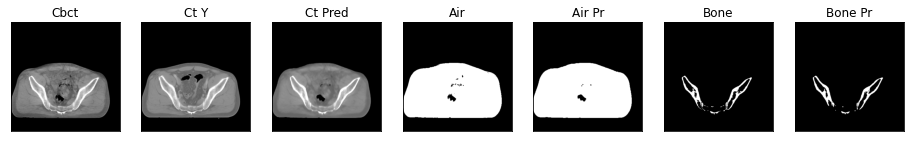

ssim score = 0.8835942149162292
psnr score = 25.185155868530273
snr score = 15.715518951416016
mae error = 0.018685655668377876
air dice score = 0.9964568097324311
bone dice score = 0.904895104896435


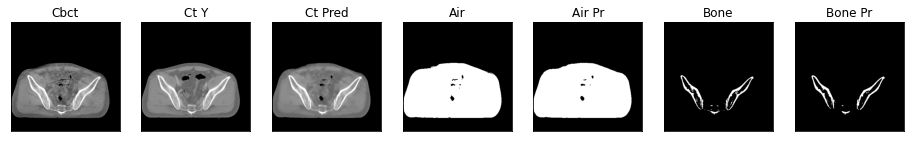

ssim score = 0.8783138394355774
psnr score = 24.74755859375
snr score = 15.21666145324707
mae error = 0.01940007507801056
air dice score = 0.9958579360183345
bone dice score = 0.8930780559662286


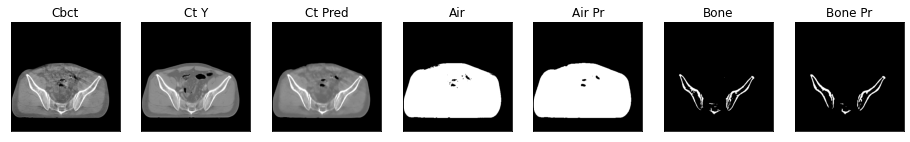

ssim score = 0.8151870369911194
psnr score = 22.27237319946289
snr score = 13.969677925109863
mae error = 0.029473913833498955
air dice score = 0.9985285673270178
bone dice score = 0.9624340267009489


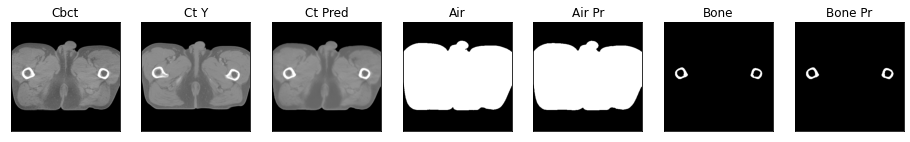

ssim score = 0.8065342307090759
psnr score = 21.967388153076172
snr score = 13.768985748291016
mae error = 0.0308210626244545
air dice score = 0.9986624896714488
bone dice score = 0.9612489545592069


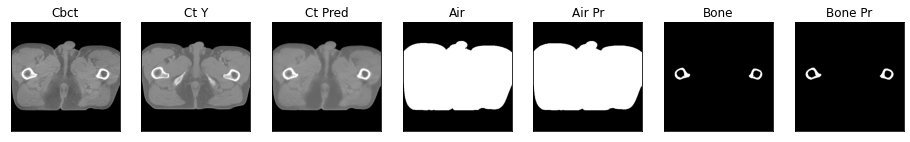

ssim score = 0.799420952796936
psnr score = 21.725358963012695
snr score = 13.654913902282715
mae error = 0.03265552595257759
air dice score = 0.9985842490300041
bone dice score = 0.9390600404780962


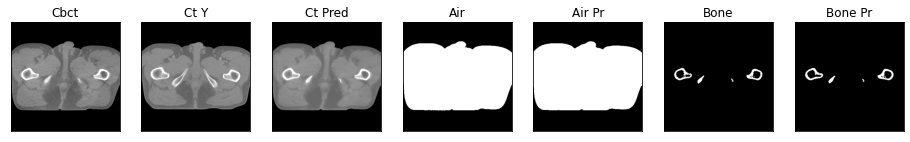

14it [00:31,  2.21s/it]

ssim score = 0.7914426922798157
psnr score = 21.271102905273438
snr score = 13.232946395874023
mae error = 0.033983830362558365
air dice score = 0.9985705847607805
bone dice score = 0.944186046512555


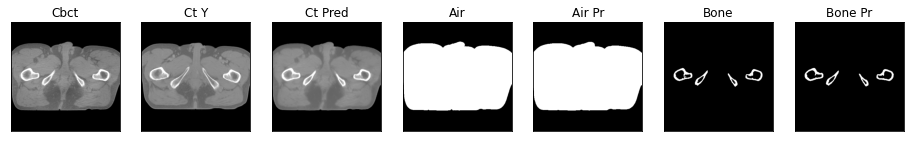

ssim score = 0.7827386856079102
psnr score = 21.1851863861084
snr score = 13.177268981933594
mae error = 0.03507331758737564
air dice score = 0.9983153876964409
bone dice score = 0.9149626744577254


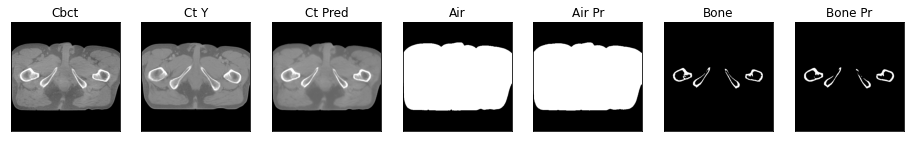

ssim score = 0.7762515544891357
psnr score = 21.0950870513916
snr score = 13.12158489227295
mae error = 0.03645365312695503
air dice score = 0.9982686472559537
bone dice score = 0.9241064638794813


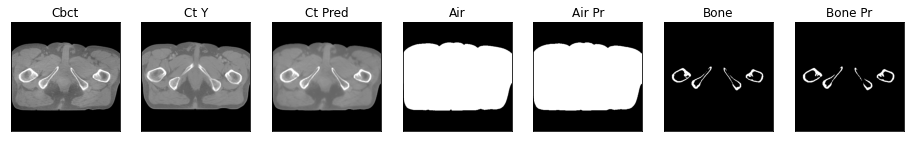

ssim score = 0.7687497138977051
psnr score = 20.814624786376953
snr score = 12.861433029174805
mae error = 0.03759020194411278
air dice score = 0.9979871034184145
bone dice score = 0.9238999598779738


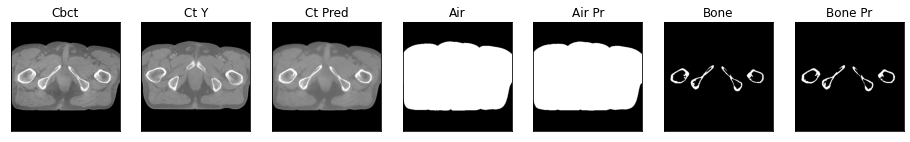

ssim score = 0.7689380645751953
psnr score = 20.88127326965332
snr score = 12.967156410217285
mae error = 0.03708522394299507
air dice score = 0.9985148804303348
bone dice score = 0.9266286320827036


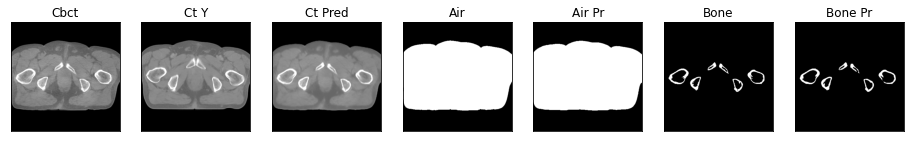

ssim score = 0.7677721381187439
psnr score = 21.05400276184082
snr score = 13.18856430053711
mae error = 0.03656725957989693
air dice score = 0.9986074705111411
bone dice score = 0.9311938382550553


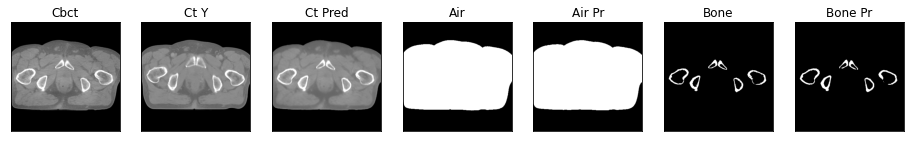

ssim score = 0.7622376084327698
psnr score = 20.862545013427734
snr score = 13.019718170166016
mae error = 0.038392286747694016
air dice score = 0.9986670252446718
bone dice score = 0.9346025466691235


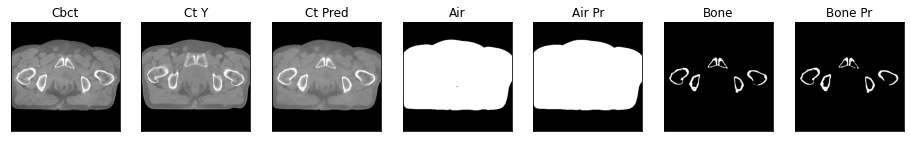

ssim score = 0.7492834329605103
psnr score = 20.7587890625
snr score = 12.958740234375
mae error = 0.03981218859553337
air dice score = 0.9987529864227034
bone dice score = 0.9230060996671307


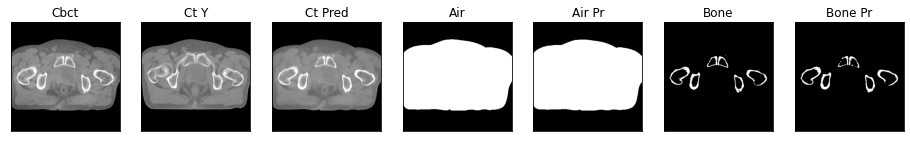

15it [00:33,  2.24s/it]

ssim score = 0.7477766275405884
psnr score = 20.720809936523438
snr score = 12.97909927368164
mae error = 0.04040677472949028
air dice score = 0.9985767646665862
bone dice score = 0.9222327740854466


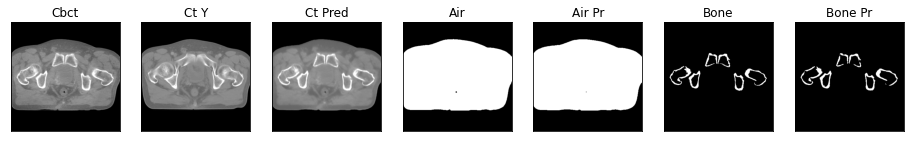

ssim score = 0.7403044104576111
psnr score = 20.382450103759766
snr score = 12.565366744995117
mae error = 0.04289592057466507
air dice score = 0.9986658313610848
bone dice score = 0.9138490926464771


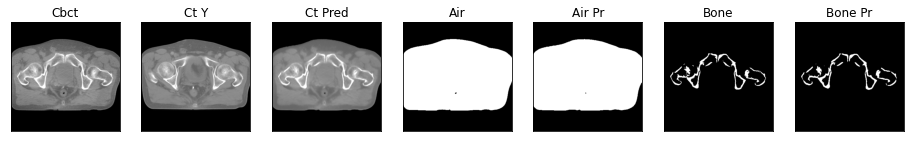

ssim score = 0.7451217770576477
psnr score = 20.193864822387695
snr score = 12.269564628601074
mae error = 0.043932992964982986
air dice score = 0.998613632804117
bone dice score = 0.9069810620134888


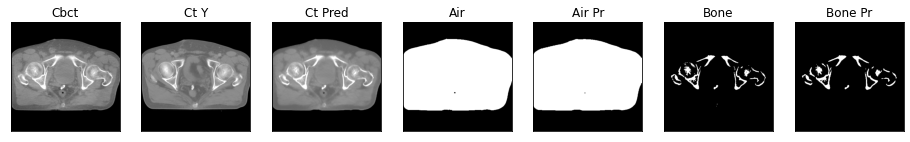

ssim score = 0.7555450797080994
psnr score = 20.39288330078125
snr score = 12.34549617767334
mae error = 0.043369319289922714
air dice score = 0.9986358068766952
bone dice score = 0.9103448275870205


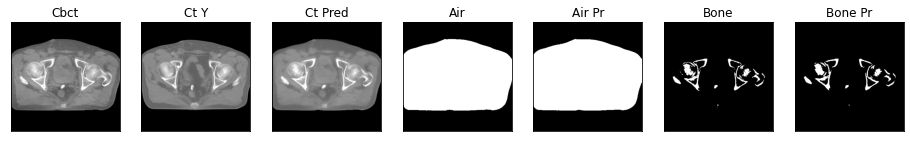

ssim score = 0.7612200379371643
psnr score = 20.645296096801758
snr score = 12.485477447509766
mae error = 0.04181294143199921
air dice score = 0.9985920245755718
bone dice score = 0.9202477370183874


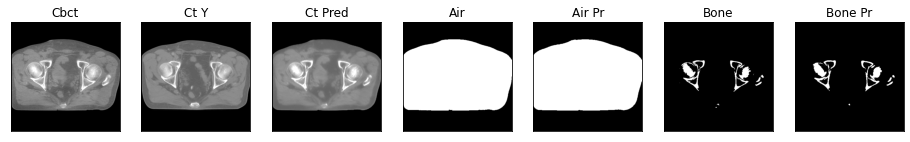

ssim score = 0.7595797777175903
psnr score = 20.981739044189453
snr score = 12.77127456665039
mae error = 0.03887308016419411
air dice score = 0.9986464884543139
bone dice score = 0.929607843137945


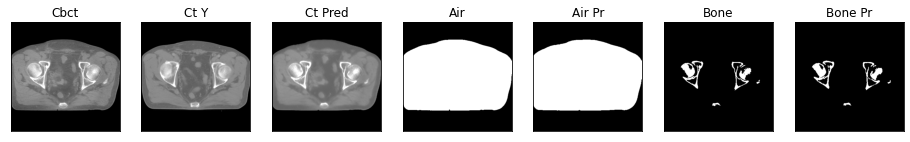

ssim score = 0.7581748962402344
psnr score = 20.86014175415039
snr score = 12.681831359863281
mae error = 0.039698872715234756
air dice score = 0.9985950287433711
bone dice score = 0.9213530212595942


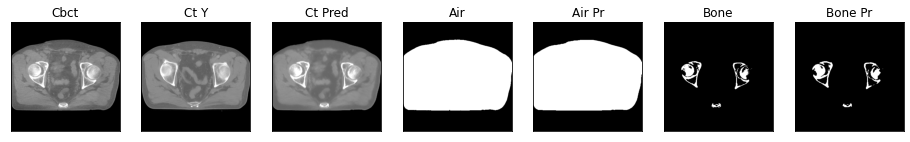

ssim score = 0.7577173709869385
psnr score = 20.703248977661133
snr score = 12.538414001464844
mae error = 0.04056302085518837
air dice score = 0.9986772564535196
bone dice score = 0.922832861190676


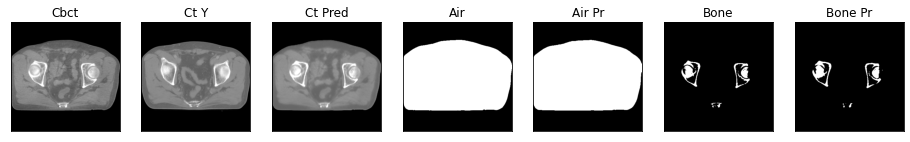

16it [00:35,  2.20s/it]

ssim score = 0.7529247999191284
psnr score = 20.150047302246094
snr score = 11.843720436096191
mae error = 0.043512482196092606
air dice score = 0.9986108730219727
bone dice score = 0.9300605245468498


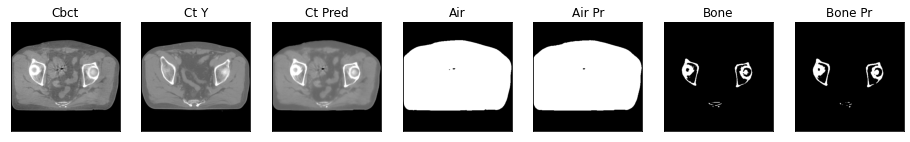

ssim score = 0.7625008821487427
psnr score = 20.264883041381836
snr score = 11.899250030517578
mae error = 0.04278286173939705
air dice score = 0.9987463683300564
bone dice score = 0.9385104691235289


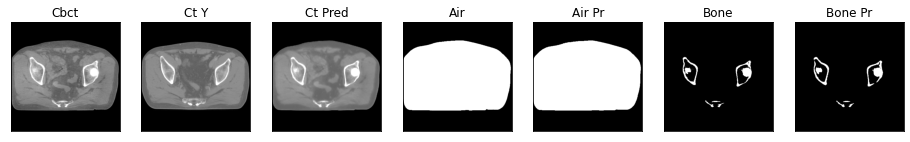

ssim score = 0.7611686587333679
psnr score = 20.733905792236328
snr score = 12.393918991088867
mae error = 0.040052950382232666
air dice score = 0.9987162569635604
bone dice score = 0.904109589042871


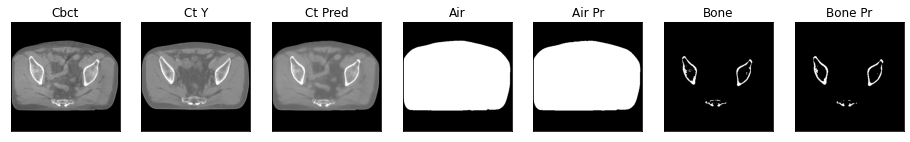

ssim score = 0.7555736899375916
psnr score = 20.67380142211914
snr score = 12.406630516052246
mae error = 0.040113408118486404
air dice score = 0.9986242858601826
bone dice score = 0.9193659545155175


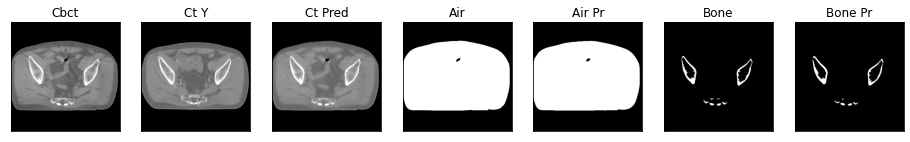

ssim score = 0.7492117881774902
psnr score = 20.36674690246582
snr score = 12.228802680969238
mae error = 0.04152671620249748
air dice score = 0.9984402959810427
bone dice score = 0.9225868110875663


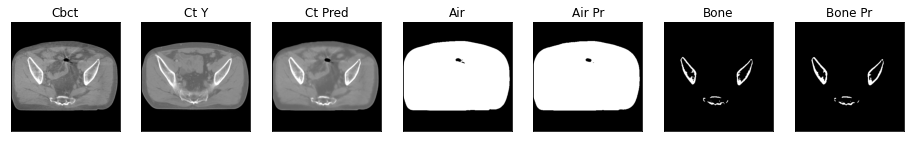

ssim score = 0.7425022721290588
psnr score = 20.151077270507812
snr score = 12.04709529876709
mae error = 0.04268914461135864
air dice score = 0.9983519123290348
bone dice score = 0.928860613072168


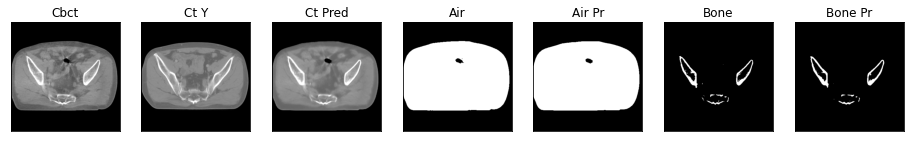

ssim score = 0.7331972718238831
psnr score = 20.11276626586914
snr score = 11.978992462158203
mae error = 0.043482765555381775
air dice score = 0.9985669770533399
bone dice score = 0.9159593544540828


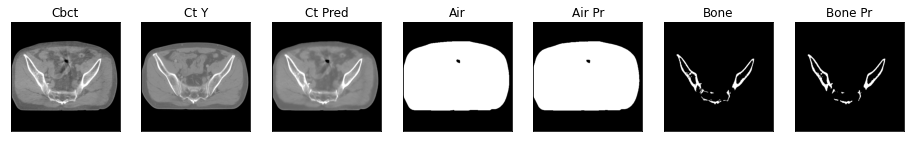

ssim score = 0.7318284511566162
psnr score = 20.33269691467285
snr score = 12.13554859161377
mae error = 0.04249900206923485
air dice score = 0.9986431313106626
bone dice score = 0.9083333333344907


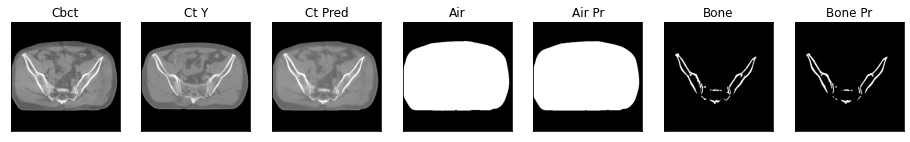

17it [00:37,  2.23s/it]

ssim score = 0.8578479290008545
psnr score = 23.84394073486328
snr score = 15.321330070495605
mae error = 0.025011921301484108
air dice score = 0.9975863754276495
bone dice score = 0.9032025908611826


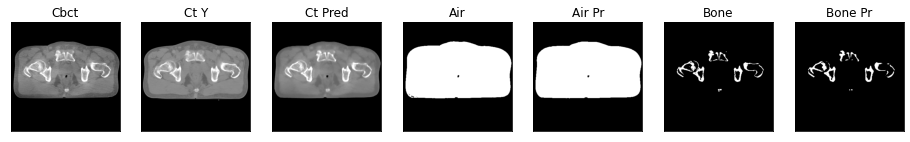

ssim score = 0.8620011210441589
psnr score = 24.14647674560547
snr score = 15.66387939453125
mae error = 0.023414192721247673
air dice score = 0.9979146120199671
bone dice score = 0.8997750562371936


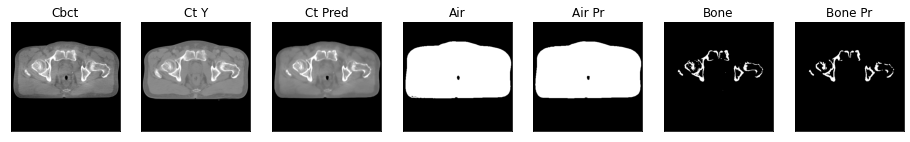

ssim score = 0.8610876798629761
psnr score = 24.260576248168945
snr score = 15.785765647888184
mae error = 0.023691002279520035
air dice score = 0.9976639387499829
bone dice score = 0.8791151594030043


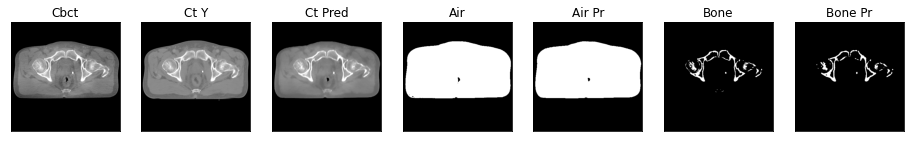

ssim score = 0.864876925945282
psnr score = 24.23253059387207
snr score = 15.699301719665527
mae error = 0.0231777373701334
air dice score = 0.997928479625011
bone dice score = 0.8812430632645055


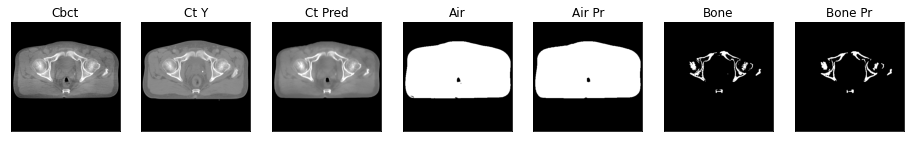

ssim score = 0.8713997006416321
psnr score = 24.428817749023438
snr score = 15.739965438842773
mae error = 0.021551232784986496
air dice score = 0.9978392230300933
bone dice score = 0.8727593300048081


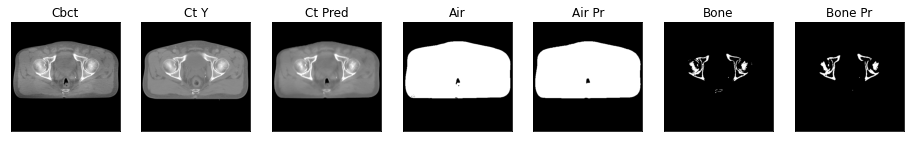

ssim score = 0.8736092448234558
psnr score = 24.557950973510742
snr score = 15.84829330444336
mae error = 0.021211322396993637
air dice score = 0.9979626898575419
bone dice score = 0.8974744027317751


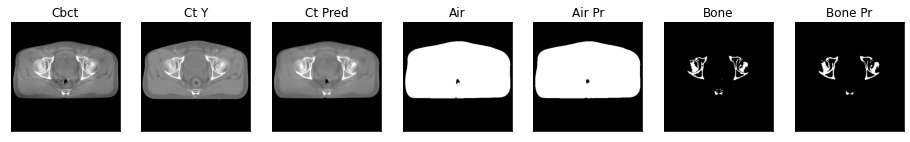

ssim score = 0.8698236346244812
psnr score = 24.474246978759766
snr score = 15.7489595413208
mae error = 0.021479234099388123
air dice score = 0.9978561237802429
bone dice score = 0.9041716646687435


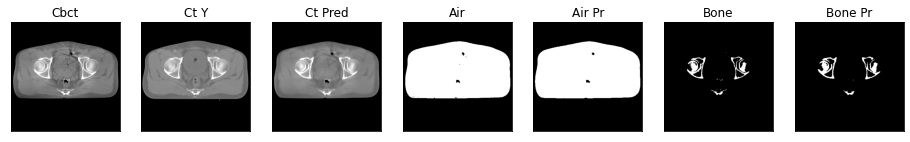

ssim score = 0.8627276420593262
psnr score = 23.807676315307617
snr score = 15.091752052307129
mae error = 0.02285350114107132
air dice score = 0.9976930800064396
bone dice score = 0.9129386552382408


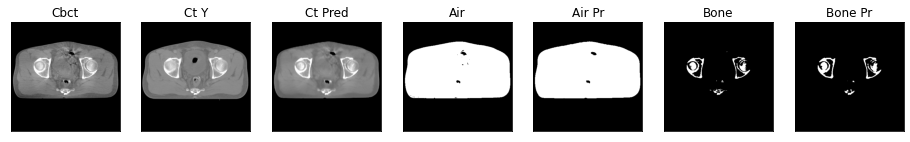

18it [00:39,  2.18s/it]

ssim score = 0.8581681847572327
psnr score = 23.908632278442383
snr score = 15.248488426208496
mae error = 0.023147230967879295
air dice score = 0.9965543762498104
bone dice score = 0.9284028324163598


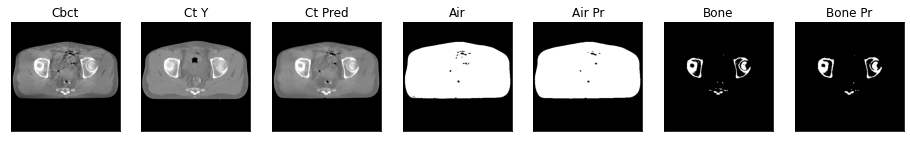

ssim score = 0.858498215675354
psnr score = 23.517494201660156
snr score = 14.83542251586914
mae error = 0.023961756378412247
air dice score = 0.9962337109933906
bone dice score = 0.9312297734637105


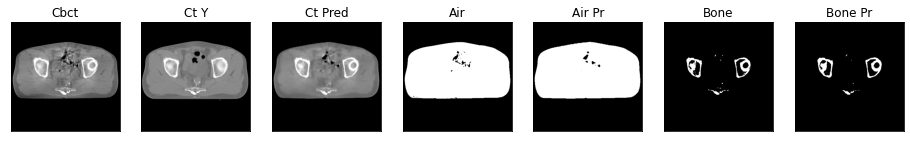

ssim score = 0.8592457175254822
psnr score = 22.813825607299805
snr score = 14.060981750488281
mae error = 0.024646494537591934
air dice score = 0.9959883608147461
bone dice score = 0.9084061464310274


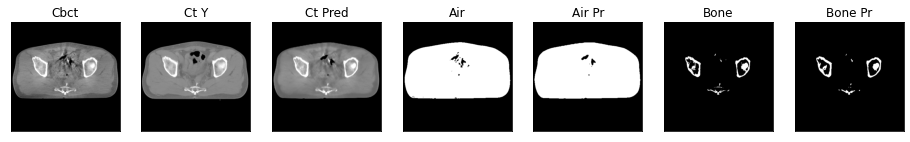

ssim score = 0.86078280210495
psnr score = 23.148998260498047
snr score = 14.35226058959961
mae error = 0.02378275617957115
air dice score = 0.9970224710388808
bone dice score = 0.9053617571074716


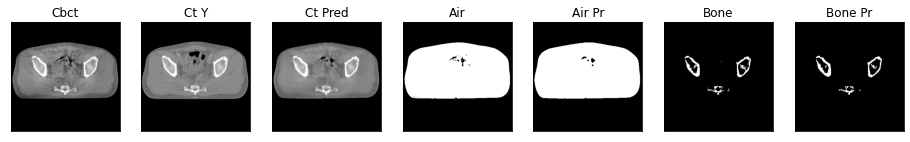

ssim score = 0.862982988357544
psnr score = 23.4860782623291
snr score = 14.688239097595215
mae error = 0.023043405264616013
air dice score = 0.9968646184248428
bone dice score = 0.9196923076935432


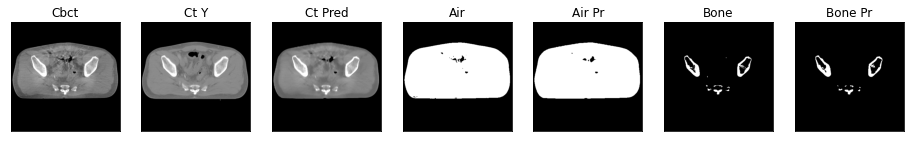

ssim score = 0.858619749546051
psnr score = 23.534954071044922
snr score = 14.750475883483887
mae error = 0.023213407024741173
air dice score = 0.9966051729950555
bone dice score = 0.9284326908721287


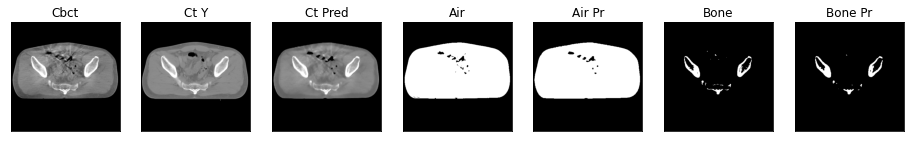

ssim score = 0.8556920289993286
psnr score = 23.43170928955078
snr score = 14.702434539794922
mae error = 0.023946985602378845
air dice score = 0.9963464566929162
bone dice score = 0.9332342375828907


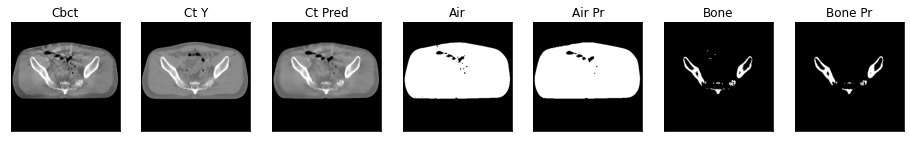

ssim score = 0.8560104370117188
psnr score = 22.85506820678711
snr score = 14.145164489746094
mae error = 0.02478998340666294
air dice score = 0.9970736478438881
bone dice score = 0.9173796450016936


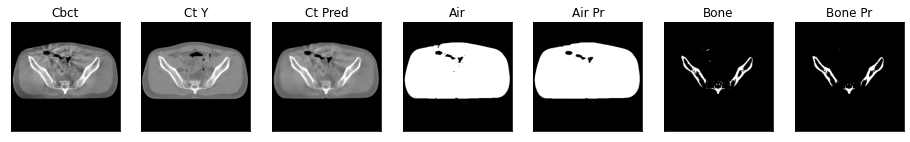

19it [00:42,  2.21s/it]

ssim score = 0.8614475727081299
psnr score = 23.011987686157227
snr score = 14.247343063354492
mae error = 0.023739006370306015
air dice score = 0.9971223361899754
bone dice score = 0.9029702970310753


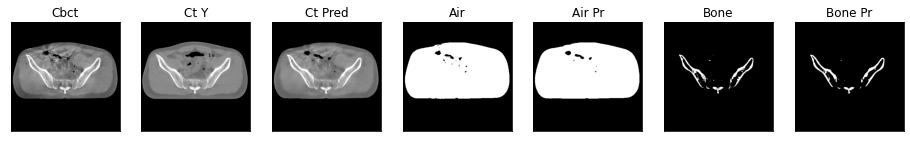

ssim score = 0.8639540672302246
psnr score = 23.372264862060547
snr score = 14.571268081665039
mae error = 0.023209644481539726
air dice score = 0.9976641577991194
bone dice score = 0.8869141464829166


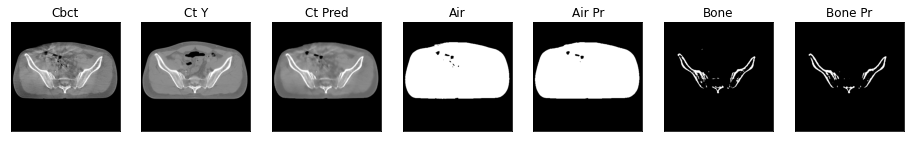

ssim score = 0.865595281124115
psnr score = 23.533035278320312
snr score = 14.732109069824219
mae error = 0.022825056686997414
air dice score = 0.9976636433004793
bone dice score = 0.8925514245573968


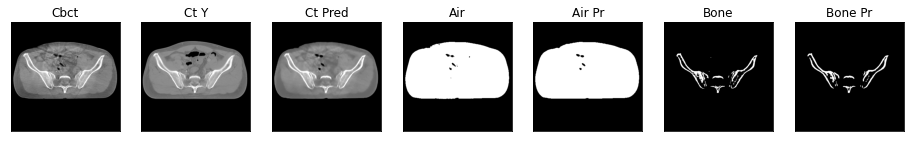

ssim score = 0.8627591729164124
psnr score = 23.57048225402832
snr score = 14.76813793182373
mae error = 0.022938771173357964
air dice score = 0.9975634950047724
bone dice score = 0.8884615384629685


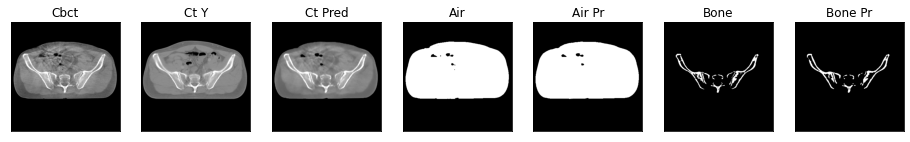

ssim score = 0.8544238209724426
psnr score = 22.921443939208984
snr score = 14.12413501739502
mae error = 0.02454979158937931
air dice score = 0.997063352223124
bone dice score = 0.890473764647345


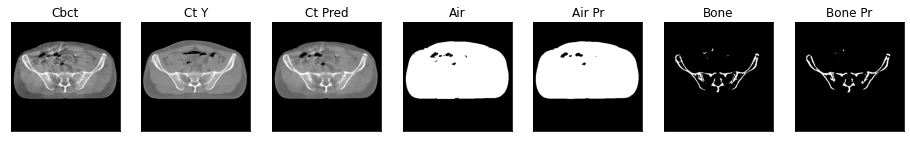

ssim score = 0.8483865857124329
psnr score = 22.317636489868164
snr score = 13.503055572509766
mae error = 0.02622477523982525
air dice score = 0.9964188649080764
bone dice score = 0.8812571283756019


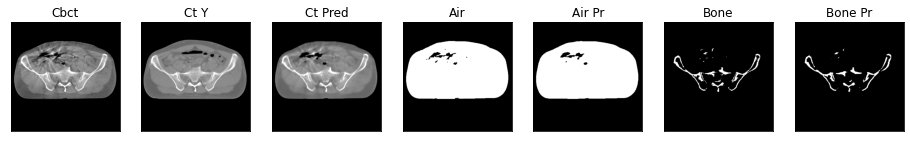

ssim score = 0.8439717888832092
psnr score = 22.04791831970215
snr score = 13.214715957641602
mae error = 0.027118420228362083
air dice score = 0.99612834961885
bone dice score = 0.890481308970614


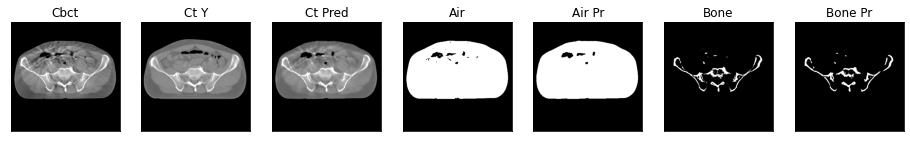

ssim score = 0.8338897824287415
psnr score = 21.61555290222168
snr score = 12.736410140991211
mae error = 0.028892338275909424
air dice score = 0.9960811452390372
bone dice score = 0.8788372093037343


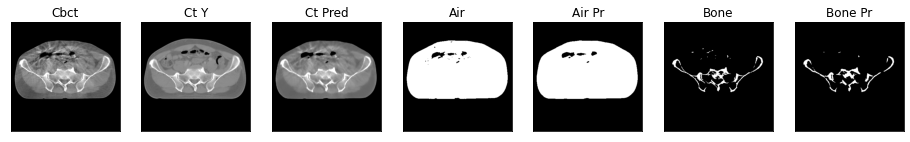

20it [00:44,  2.17s/it]

ssim score = 0.8276716470718384
psnr score = 21.534433364868164
snr score = 12.601495742797852
mae error = 0.02970569021999836
air dice score = 0.9964976421771267
bone dice score = 0.8904942093809138


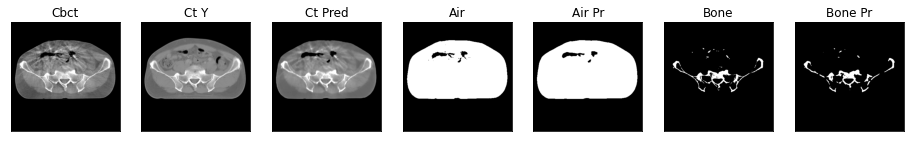

ssim score = 0.819527268409729
psnr score = 21.207406997680664
snr score = 12.304930686950684
mae error = 0.03158120438456535
air dice score = 0.9965340627764864
bone dice score = 0.9004621801386488


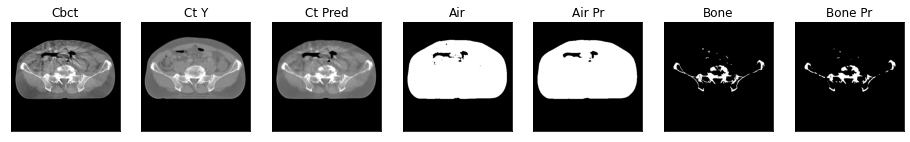

ssim score = 0.8133034706115723
psnr score = 20.967693328857422
snr score = 12.009991645812988
mae error = 0.03191293776035309
air dice score = 0.9965364727308234
bone dice score = 0.8885167464128166


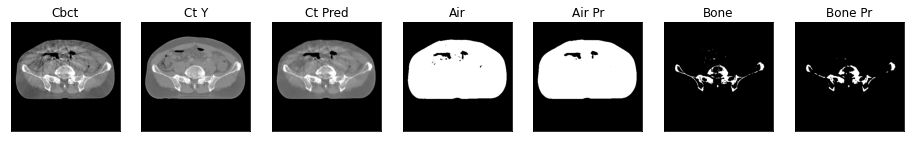

ssim score = 0.8243213295936584
psnr score = 21.722841262817383
snr score = 12.617609024047852
mae error = 0.028951426967978477
air dice score = 0.9970283041847348
bone dice score = 0.9088657751373345


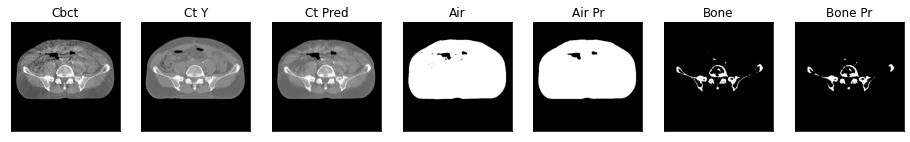

ssim score = 0.8850276470184326
psnr score = 26.638280868530273
snr score = 17.019193649291992
mae error = 0.016436291858553886
air dice score = 0.9987067451091801
bone dice score = 0.9418761827536665


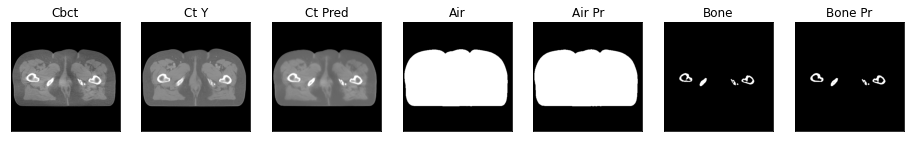

ssim score = 0.8841902017593384
psnr score = 26.691837310791016
snr score = 17.193761825561523
mae error = 0.01652507670223713
air dice score = 0.9984250564602413
bone dice score = 0.9419237749559455


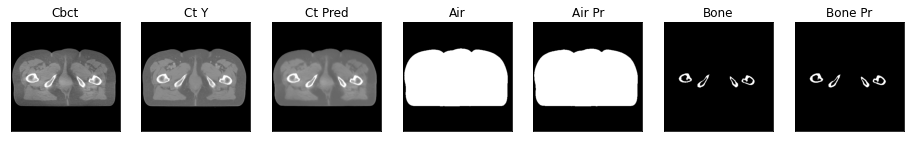

ssim score = 0.8801508545875549
psnr score = 26.56339454650879
snr score = 17.148235321044922
mae error = 0.017075607553124428
air dice score = 0.9982279191340444
bone dice score = 0.9242863053387611


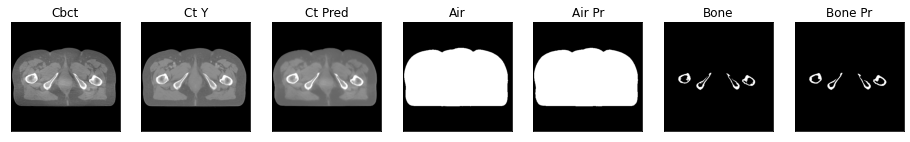

ssim score = 0.8773187398910522
psnr score = 26.445703506469727
snr score = 17.093990325927734
mae error = 0.01761196367442608
air dice score = 0.9982366943897506
bone dice score = 0.9180085137901535


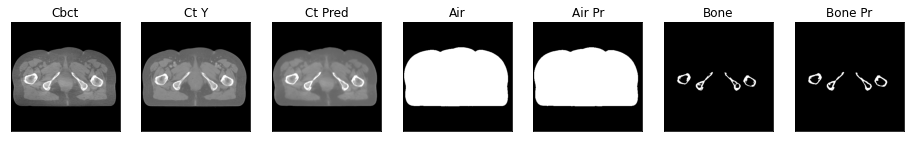

21it [00:46,  2.20s/it]

ssim score = 0.8776217699050903
psnr score = 26.31191062927246
snr score = 16.988658905029297
mae error = 0.017705613747239113
air dice score = 0.9982939277006112
bone dice score = 0.927725746599616


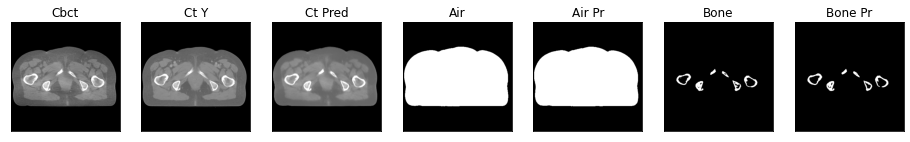

ssim score = 0.8791276216506958
psnr score = 26.267227172851562
snr score = 16.96693229675293
mae error = 0.017518727108836174
air dice score = 0.9980937913103191
bone dice score = 0.9244281793243472


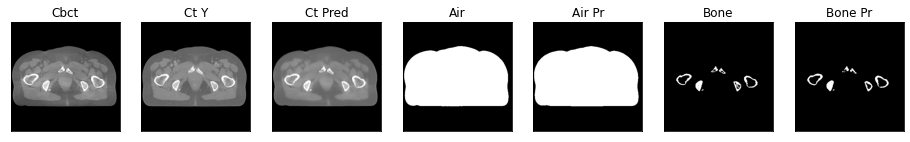

ssim score = 0.8762452602386475
psnr score = 26.16335105895996
snr score = 16.894380569458008
mae error = 0.017752164974808693
air dice score = 0.998258360235232
bone dice score = 0.9160636758336458


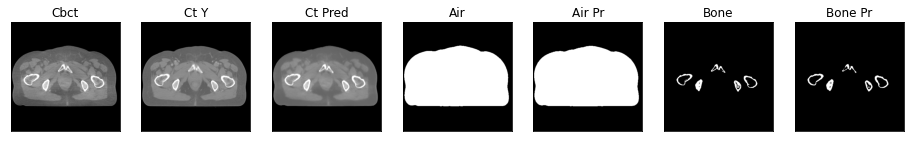

ssim score = 0.8751029372215271
psnr score = 25.832374572753906
snr score = 16.61176872253418
mae error = 0.01842525228857994
air dice score = 0.9978433515482712
bone dice score = 0.9201960098018866


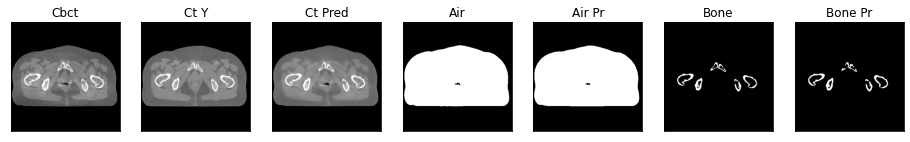

ssim score = 0.8756518363952637
psnr score = 25.48443031311035
snr score = 16.306568145751953
mae error = 0.018776556476950645
air dice score = 0.9978865438432851
bone dice score = 0.9220862846116856


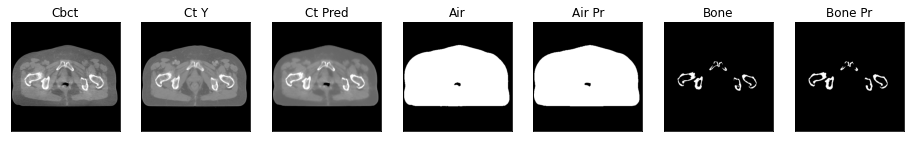

ssim score = 0.8713729977607727
psnr score = 25.314550399780273
snr score = 16.224388122558594
mae error = 0.019509196281433105
air dice score = 0.9980463624435063
bone dice score = 0.9119619899397434


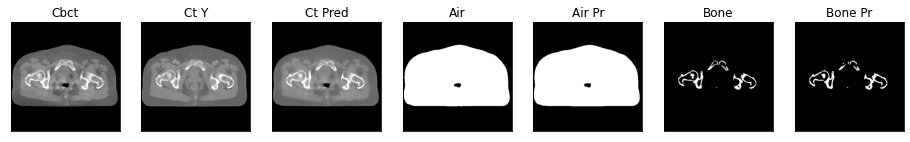

ssim score = 0.8748281598091125
psnr score = 26.257301330566406
snr score = 17.280412673950195
mae error = 0.018912876024842262
air dice score = 0.9981136455975405
bone dice score = 0.9181679029798873


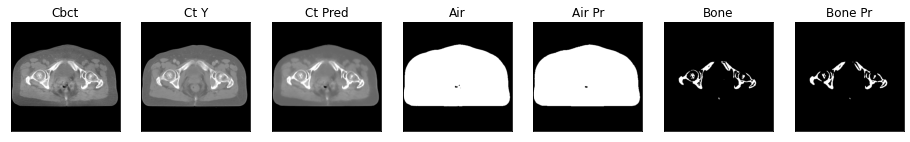

ssim score = 0.878788948059082
psnr score = 25.664600372314453
snr score = 16.559160232543945
mae error = 0.018814468756318092
air dice score = 0.9979706581904687
bone dice score = 0.8909551986493499


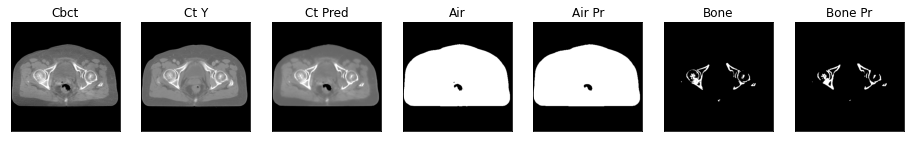

22it [00:48,  2.23s/it]

ssim score = 0.8802137970924377
psnr score = 25.788654327392578
snr score = 16.573793411254883
mae error = 0.01844809576869011
air dice score = 0.9980672256695696
bone dice score = 0.8762631077239988


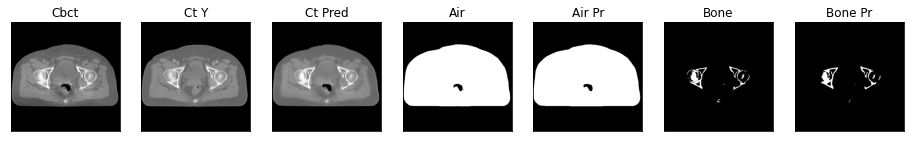

ssim score = 0.8818807601928711
psnr score = 25.6453914642334
snr score = 16.403404235839844
mae error = 0.01926301047205925
air dice score = 0.9983924925055405
bone dice score = 0.899337973181135


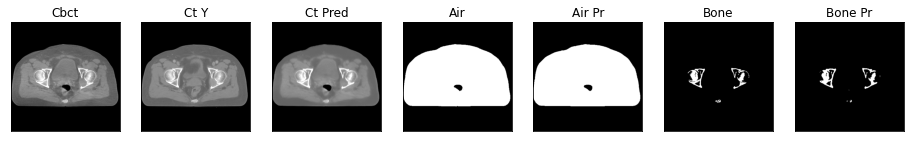

ssim score = 0.8830747008323669
psnr score = 26.14224624633789
snr score = 16.892253875732422
mae error = 0.019451426342129707
air dice score = 0.998470937035629
bone dice score = 0.9159212880156786


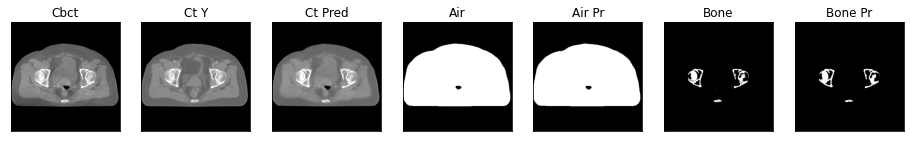

ssim score = 0.8829253911972046
psnr score = 26.858943939208984
snr score = 17.64318084716797
mae error = 0.01829499937593937
air dice score = 0.9986916392906419
bone dice score = 0.9312152991990867


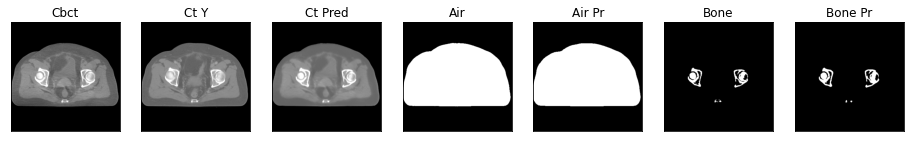

ssim score = 0.8781106472015381
psnr score = 26.38868522644043
snr score = 17.224414825439453
mae error = 0.018676184117794037
air dice score = 0.9985462449365581
bone dice score = 0.945690855640636


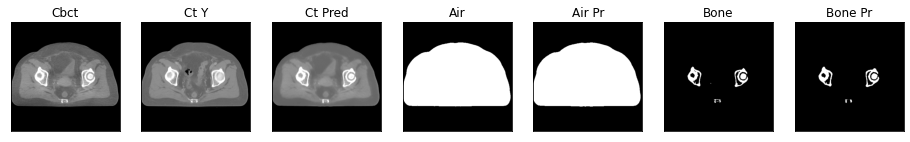

ssim score = 0.8662524819374084
psnr score = 25.495336532592773
snr score = 16.368621826171875
mae error = 0.020074646919965744
air dice score = 0.9983417644465913
bone dice score = 0.9393888232324938


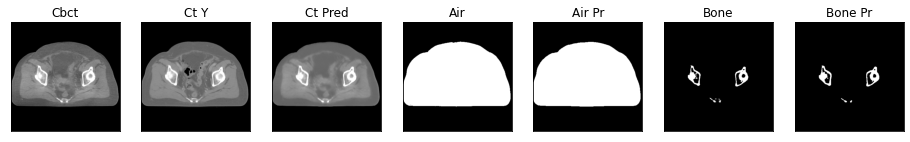

ssim score = 0.8512881994247437
psnr score = 23.787952423095703
snr score = 14.588799476623535
mae error = 0.023079756647348404
air dice score = 0.9976131326416305
bone dice score = 0.9203230735664631


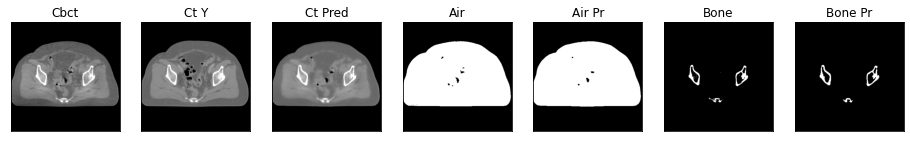

ssim score = 0.8442202210426331
psnr score = 23.434293746948242
snr score = 14.21714973449707
mae error = 0.024467745795845985
air dice score = 0.9974110838836528
bone dice score = 0.9357878588661892


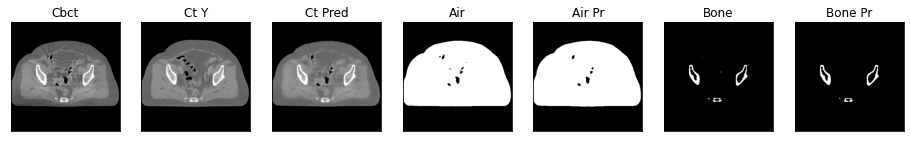

23it [00:50,  2.18s/it]

ssim score = 0.8428298234939575
psnr score = 23.998363494873047
snr score = 14.8461332321167
mae error = 0.023861445486545563
air dice score = 0.997361839174977
bone dice score = 0.9302424500227511


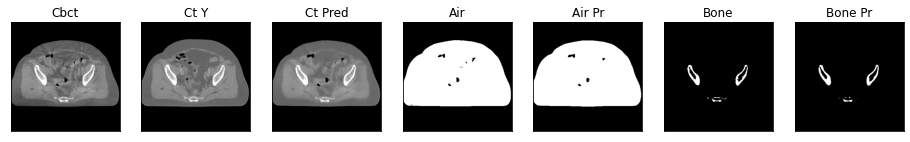

ssim score = 0.8431419730186462
psnr score = 24.172157287597656
snr score = 15.075023651123047
mae error = 0.02365705743432045
air dice score = 0.9973707274320789
bone dice score = 0.9334300743708792


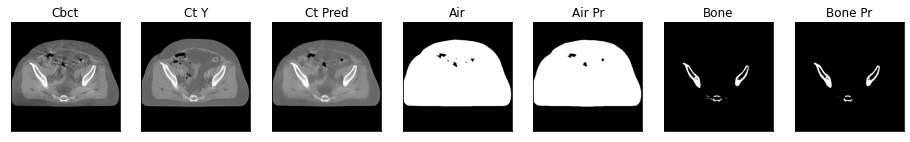

ssim score = 0.8388959765434265
psnr score = 23.533647537231445
snr score = 14.50094223022461
mae error = 0.025144362822175026
air dice score = 0.997700005380106
bone dice score = 0.9330085261885961


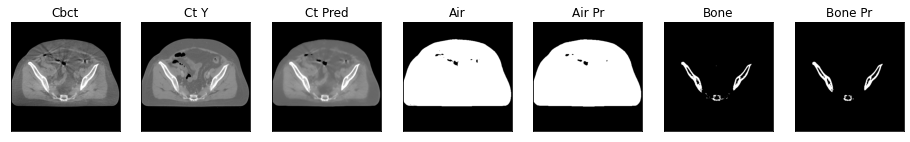

ssim score = 0.8386058211326599
psnr score = 23.414642333984375
snr score = 14.454793930053711
mae error = 0.02554846927523613
air dice score = 0.9973844696211501
bone dice score = 0.9111913357413547


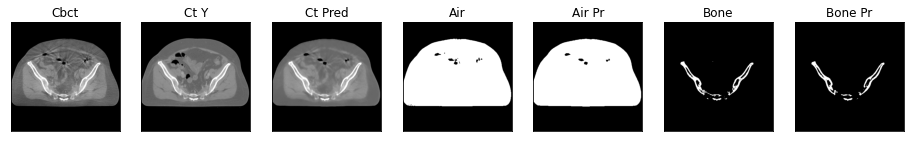

ssim score = 0.8367342352867126
psnr score = 23.233314514160156
snr score = 14.26917839050293
mae error = 0.02631114050745964
air dice score = 0.9978276994807687
bone dice score = 0.9064727272740877


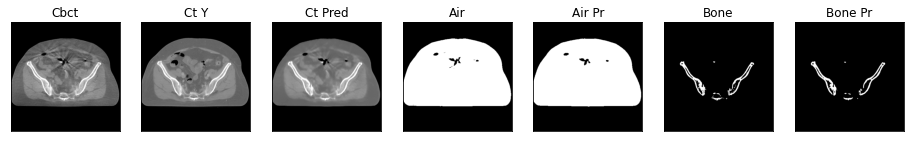

ssim score = 0.836857259273529
psnr score = 23.343107223510742
snr score = 14.356794357299805
mae error = 0.026185519993305206
air dice score = 0.9976885652734776
bone dice score = 0.9028666852226153


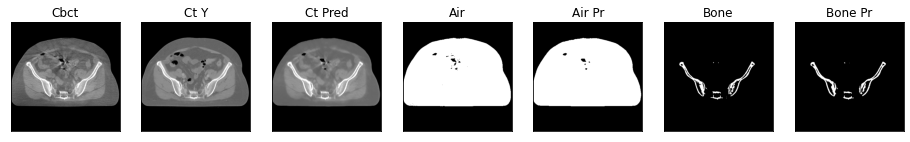

ssim score = 0.8441474437713623
psnr score = 24.15442657470703
snr score = 15.179749488830566
mae error = 0.024430623278021812
air dice score = 0.9980816591056396
bone dice score = 0.9025686448198617


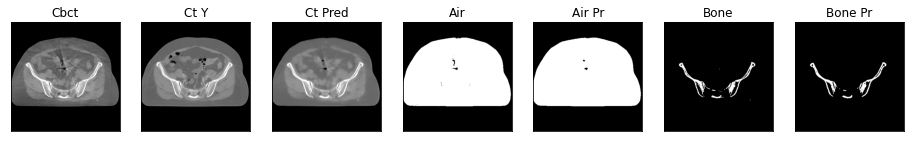

24it [00:53,  2.21s/it]


In [32]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [33]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [34]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [35]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:07,  3.39it/s]


(0.8503714526693026,
 23.645752509435017,
 14.660322904586792,
 0.024994051006312173,
 0.9968593428920579,
 0.9207977894180436,
 0.3333333333333333)